<a href="https://colab.research.google.com/github/ElZho/Translate-from-old-russian-language.Seq2seq-model./blob/main/Seq2Seq_translation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sources:**

Baseline - [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial)

Embeddings -https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

https://python-school.ru/blog/word2vec-with-examples-in-gensim/

Dataloader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

Self attention and pad_packed_sequence https://discuss.pytorch.org/t/self-attention-on-words-and-masking/5671

https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html


In this notebook I try to realize:
1. **To convert data to dataloader using**. This allow me to use batches to speed lerning process. More over batches can make results better. For do this I have to pad sentences. The sentences should be the same length for dataloader using. And I have to make some changes in model for load date by batches.
2. **To make some changes in baseline model.** I join encoder and decoder with attention to single model. To do this I make encoder forward to work with whole batch, not with only one word like in baseline model. Decoder forward I keep unchanged, except that I pass for one word from whole batch, so that decoder works with tensor size equal to batch size. Padding the sentences can make model work worser, to I add mask to attention and use *pad_packed_sequence* in encoder to nevilate padding. I change Attention to work with encoder output, not with decoder imput like in baseline model.
3. **I try to use Word2vec** embeddings to improve model.
4. **I try different loss functions and optimizers.**
5. **I add bleu_score metric to estimate results.**

In [1]:
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import tqdm
from tqdm import tqdm

In [3]:
import unicodedata
import string
import re
import random
import itertools

In [4]:
import time
import math
from collections import defaultdict

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [6]:
import os
from pathlib import Path
import sys

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/My\ Drive/NLP_translation/* . 

Mounted at /content/drive


In [7]:
from preprocessing import prepareData, readLangs, tensorsFromPair, tensorFromSentence

In [ ]:
SOS_token = 1
EOS_token = 0

In [8]:
config = {  
    'path'  :'/content/drive/MyDrive/NLP_translation/old_slav.txt', #old slavenic - rus
    #'path':'/content/rus.txt', #rus-eng
    'MAX_LENGTH':20,
    'reverse':True,
    'pad_index':[0,1],
    
    'batch_size':8, # for short datasets use batch_size - 8, for big dataset - 256

    'teacher_forcing_ratio': 0.5,
    'hidden_size':256,
    'num_epochs':100,
    
    'lr': 0.01
}

In [9]:
from model import EncoderRNN, AttnDecoderRNN, TONModel

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
train_input_lang, train_output_lang, train_pairs, test_input_lang,\
           test_output_lang, test_pairs = prepareData('old_rus', 'new_rus', config['path'], config['MAX_LENGTH'], config['reverse'])
print(random.choice(train_pairs))

Reading lines...


100%|██████████| 229/229 [00:00<00:00, 730970.79it/s]

Read 159 sentence pairs train
Read 69 sentence pairs test
Trimmed to 159 sentence train pairs
Trimmed to 69 sentence test pairs
Counting words...
Counted words train:
old_rus 738
new_rus 698
Counted words test:
old_rus 403
new_rus 388
['и ѡномy мьнyщю оyсние', 'когда он мял кожу ']


Check lengths of sentences

In [30]:
#max length of train sentence
len_train=([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in train_pairs)
max(len_train)

[24, 25]

In [ ]:
#max length of test sentence
max([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in test_pairs)

[20, 24]

In [31]:
def len_pair(pair):
  len_0=len(pair[0].split(' '))
  len_1=len(pair[1].split(' '))
  return len_0, len_1
len_train_old=[] 
len_train_new=[] 
for pair in train_pairs:  
  old, new=len_pair(pair)
  len_train_old.append(old)
  len_train_new.append(new)

Plot histogramm for length of source sentence

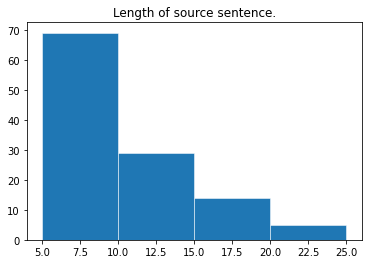

In [36]:
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of source sentence.');



Plot histogramm for length of target sentence

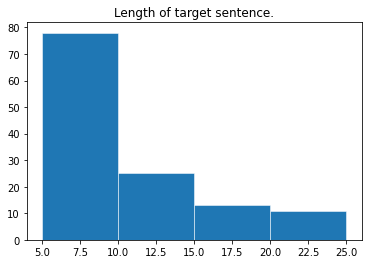

In [41]:
fig, ax = plt.subplots()
ax.hist(len_train_new, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of target sentence.');

Make DataLoaders for train and test sentences.

For use dataloader I add padding sentences to max length in tensorFromSentence. 
To use pad_packed_sentence I add get_len function to get true length of sentence.

In [12]:
training_pairs = [tensorsFromPair(train_pair, train_input_lang, train_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for train_pair in tqdm(train_pairs)]
testing_pairs = [tensorsFromPair(test_pair, test_input_lang, test_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for test_pair in tqdm(test_pairs)]
train_loader = torch.utils.data.DataLoader(training_pairs, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_pairs, batch_size=config['batch_size'], shuffle=False)   #Test dataloader without shuffling pairs to have comparable results for validation loop                                         

100%|██████████| 69/69 [00:00<00:00, 13274.94it/s]


Make helper functions.

In [13]:
#function to check time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
#function to plot loss curves
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(10,5))

    # plt.subplot(1,3,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

Create a traning model using dataloader.
Made changes: 
1. epoch iteration. Each epoch is train on all train dataset and validate on test dataset.
2. Encoder and decoder comunication is in model. In training model function I just pass input tensor, output tensor and input sentence length into model and get decoder output out.
3. I use batches to load data, so outputs and target have to be transformed to pass to loss function.
4. I collect train and validation loss for each epoch into defaultdict.
5. I plot train and validation loss after the training.
6. I save best model during the training.

In [22]:
#model with data loader
def train_modelIters(model, optimizer, loader, test_loader, criterion, num_epochs=6):
    start = time.time() #start time
    itog_losses = []
    best_loss=np.inf #initiate best loss to check and save model with best loss.

    history = defaultdict(lambda: defaultdict(list))  #dictionry to collect losses  
      
    for epoch in tqdm(range(num_epochs), desc='epochs'):
      model.train(True)      

      plot_losses = []
      #print_loss_total = 0  
      plot_loss_total = 0

      val_losses = []
      val_loss_total = 0  
      
      #train loop
      for batch in tqdm(loader, desc='train sample batches'):
          
          input_tensor = batch[0].to(device)
          input_len=batch[1]          #true length  of sentences in batches withput padding
          target_tensor = batch[2].to(device)                           
         
          decoder_outputs, _ = model(input_tensor[:,:,0], input_len, target_tensor[:,:,0])
          
          target_tensor = target_tensor.view(-1) #change dimantion in one size
          output_dim = decoder_outputs.shape[-1]  #change dimantion in one size
          decoder_outputs=decoder_outputs.view(-1, output_dim)  #change dimantion in one size
          
          loss = criterion(decoder_outputs, target_tensor)      #calculate loss
          
          loss.backward(retain_graph=True)    
          optimizer.step()
          optimizer.zero_grad()                   
          
          plot_loss_total += loss.item() #collect losses
          
      plot_loss_avg = plot_loss_total /  len(loader)
      history['loss']['train'].append(plot_loss_avg)
      
      model.train(False)
      #validation loop
      for batch in tqdm(test_loader, desc='validation sample batches'):
        
        input_tensor = batch[0].to(device)
        input_len=batch[1]
        target_tensor = batch[2].to(device)
               
        with torch.no_grad():
          decoder_outputs, _ = model(input_tensor[:,:,0], input_len, target_tensor[:,:,0],
                                  evalute=True)
          
          target_tensor = target_tensor.view(-1)
          output_dim = decoder_outputs.shape[-1]            
          decoder_outputs=decoder_outputs.view(-1, output_dim)    
          
          val_loss = criterion(decoder_outputs, target_tensor) # calculate validation loss          
          val_loss_total+= loss.item() #collect loss item

      val_loss_avg = val_loss_total / len(test_loader)    
      history['loss']['val'].append(val_loss_avg)
      print('Epoch train loss', plot_loss_avg, end='\n')
      print('Epoch val_loss', val_loss_avg, end='\n')

      if val_loss_avg<best_loss: #save best model
        best_loss=val_loss
        torch.save(model, 'best_model.pt')

    plot_learning_curves(history) #plot loss curves
    return 

Train model using SGD optimizer and NLLLos

train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]

epochs:   1%|          | 1/100 [00:05<09:10,  5.56s/it]

Epoch train loss 6.516159653663635
Epoch val_loss 6.483398914337158



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s]

epochs:   2%|▏         | 2/100 [00:11<09:08,  5.60s/it]

Epoch train loss 6.443923592567444
Epoch val_loss 6.315349102020264



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]

epochs:   3%|▎         | 3/100 [00:17<09:28,  5.86s/it]

Epoch train loss 6.342734408378601
Epoch val_loss 6.245072841644287



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]

epochs:   4%|▍         | 4/100 [00:22<09:13,  5.76s/it]

Epoch train loss 6.212547850608826
Epoch val_loss 6.241044521331787



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]

epochs:   5%|▌         | 5/100 [00:28<08:58,  5.67s/it]

Epoch train loss 6.050944995880127
Epoch val_loss 5.778976917266846



train sample batches: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]

epochs:   6%|▌         | 6/100 [00:36<10:02,  6.41s/it]

Epoch train loss 5.897995734214783
Epoch val_loss 5.707559108734131



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.69it/s]

epochs:   7%|▋         | 7/100 [00:42<09:45,  6.29s/it]

Epoch train loss 5.81817855834961
Epoch val_loss 5.771047115325928



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]

epochs:   8%|▊         | 8/100 [00:47<09:15,  6.04s/it]

Epoch train loss 5.78685691356659
Epoch val_loss 5.861900329589844



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]

epochs:   9%|▉         | 9/100 [00:53<08:53,  5.86s/it]

Epoch train loss 5.751968884468079
Epoch val_loss 5.768308639526367



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]

epochs:  10%|█         | 10/100 [00:58<08:37,  5.75s/it]

Epoch train loss 5.733344602584839
Epoch val_loss 5.908931255340576



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.95it/s]

epochs:  11%|█         | 11/100 [01:04<08:29,  5.73s/it]

Epoch train loss 5.728212141990662
Epoch val_loss 5.5471577644348145



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]

epochs:  12%|█▏        | 12/100 [01:10<08:18,  5.66s/it]

Epoch train loss 5.698440337181092
Epoch val_loss 5.80905294418335



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]

epochs:  13%|█▎        | 13/100 [01:16<08:23,  5.79s/it]

Epoch train loss 5.672390747070312
Epoch val_loss 5.452648162841797



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]

epochs:  14%|█▍        | 14/100 [01:21<08:10,  5.70s/it]

Epoch train loss 5.654334831237793
Epoch val_loss 5.559378147125244



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]

epochs:  15%|█▌        | 15/100 [01:27<07:58,  5.63s/it]

Epoch train loss 5.649682569503784
Epoch val_loss 5.647377967834473



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]

epochs:  16%|█▌        | 16/100 [01:32<07:52,  5.62s/it]

Epoch train loss 5.634405088424683
Epoch val_loss 5.866407871246338



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.99it/s]

epochs:  17%|█▋        | 17/100 [01:38<07:47,  5.63s/it]

Epoch train loss 5.626114559173584
Epoch val_loss 5.661492347717285



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]

epochs:  18%|█▊        | 18/100 [01:43<07:39,  5.61s/it]

Epoch train loss 5.613649368286133
Epoch val_loss 5.337573051452637



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]

epochs:  19%|█▉        | 19/100 [01:49<07:31,  5.58s/it]

Epoch train loss 5.606714105606079
Epoch val_loss 5.247134685516357



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]

epochs:  20%|██        | 20/100 [01:54<07:26,  5.58s/it]

Epoch train loss 5.594258213043213
Epoch val_loss 5.498928070068359



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]

epochs:  21%|██        | 21/100 [02:00<07:21,  5.59s/it]

Epoch train loss 5.588881087303162
Epoch val_loss 5.620169639587402



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]

epochs:  22%|██▏       | 22/100 [02:06<07:15,  5.58s/it]

Epoch train loss 5.583388376235962
Epoch val_loss 5.417802333831787



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]

epochs:  23%|██▎       | 23/100 [02:11<07:08,  5.57s/it]

Epoch train loss 5.574512028694153
Epoch val_loss 5.584427356719971



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.99it/s]

epochs:  24%|██▍       | 24/100 [02:17<07:04,  5.59s/it]

Epoch train loss 5.598594331741333
Epoch val_loss 5.268038272857666



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]

epochs:  25%|██▌       | 25/100 [02:22<06:58,  5.58s/it]

Epoch train loss 5.575782918930054
Epoch val_loss 5.549621105194092



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]

epochs:  26%|██▌       | 26/100 [02:28<06:50,  5.55s/it]

Epoch train loss 5.57106032371521
Epoch val_loss 5.750106334686279



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]

epochs:  27%|██▋       | 27/100 [02:34<06:47,  5.58s/it]

Epoch train loss 5.5455506324768065
Epoch val_loss 5.6633734703063965



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]

epochs:  28%|██▊       | 28/100 [02:39<06:42,  5.59s/it]

Epoch train loss 5.544520974159241
Epoch val_loss 5.7476630210876465



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.00it/s]

epochs:  29%|██▉       | 29/100 [02:45<06:37,  5.60s/it]

Epoch train loss 5.552594995498657
Epoch val_loss 5.500824928283691



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]

epochs:  30%|███       | 30/100 [02:50<06:31,  5.60s/it]

Epoch train loss 5.546908211708069
Epoch val_loss 5.864975929260254



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  31%|███       | 31/100 [02:55<06:04,  5.29s/it]

Epoch train loss 5.535340738296509
Epoch val_loss 5.200838565826416



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  32%|███▏      | 32/100 [03:00<05:48,  5.13s/it]

Epoch train loss 5.512995290756225
Epoch val_loss 5.459131240844727



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  33%|███▎      | 33/100 [03:04<05:31,  4.94s/it]

Epoch train loss 5.518715262413025
Epoch val_loss 5.588807106018066



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]

epochs:  34%|███▍      | 34/100 [03:08<05:09,  4.70s/it]

Epoch train loss 5.511315035820007
Epoch val_loss 5.391821384429932



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  35%|███▌      | 35/100 [03:13<04:58,  4.59s/it]

Epoch train loss 5.491441297531128
Epoch val_loss 5.459286212921143



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

epochs:  36%|███▌      | 36/100 [03:17<04:43,  4.43s/it]

Epoch train loss 5.498707056045532
Epoch val_loss 5.347605228424072



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]

epochs:  37%|███▋      | 37/100 [03:21<04:33,  4.34s/it]

Epoch train loss 5.475076699256897
Epoch val_loss 5.667860507965088



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  38%|███▊      | 38/100 [03:25<04:29,  4.35s/it]

Epoch train loss 5.489249658584595
Epoch val_loss 5.495707035064697



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

epochs:  39%|███▉      | 39/100 [03:29<04:20,  4.27s/it]

Epoch train loss 5.483415412902832
Epoch val_loss 5.499804973602295



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  40%|████      | 40/100 [03:34<04:19,  4.33s/it]

Epoch train loss 5.486553430557251
Epoch val_loss 5.417395114898682



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]

epochs:  41%|████      | 41/100 [03:38<04:17,  4.37s/it]

Epoch train loss 5.4786893129348755
Epoch val_loss 5.275063991546631



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]

epochs:  42%|████▏     | 42/100 [03:42<04:09,  4.30s/it]

Epoch train loss 5.470228910446167
Epoch val_loss 5.718736171722412



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

epochs:  43%|████▎     | 43/100 [03:46<04:02,  4.25s/it]

Epoch train loss 5.4509113073349
Epoch val_loss 5.292231559753418



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]

epochs:  44%|████▍     | 44/100 [03:51<03:54,  4.19s/it]

Epoch train loss 5.457620787620544
Epoch val_loss 5.674703121185303



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s]

epochs:  45%|████▌     | 45/100 [03:55<03:55,  4.27s/it]

Epoch train loss 5.449728393554688
Epoch val_loss 5.576359748840332



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]

epochs:  46%|████▌     | 46/100 [03:59<03:48,  4.23s/it]

Epoch train loss 5.45273368358612
Epoch val_loss 5.573012351989746



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

epochs:  47%|████▋     | 47/100 [04:03<03:41,  4.18s/it]

Epoch train loss 5.445976519584656
Epoch val_loss 5.4255499839782715



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

epochs:  48%|████▊     | 48/100 [04:08<03:41,  4.26s/it]

Epoch train loss 5.435476851463318
Epoch val_loss 5.643794536590576



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]

epochs:  49%|████▉     | 49/100 [04:12<03:46,  4.43s/it]

Epoch train loss 5.4371384382247925
Epoch val_loss 5.442917346954346



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

epochs:  50%|█████     | 50/100 [04:17<03:38,  4.37s/it]

Epoch train loss 5.437596917152405
Epoch val_loss 5.659327507019043



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  51%|█████     | 51/100 [04:21<03:35,  4.41s/it]

Epoch train loss 5.447580480575562
Epoch val_loss 5.6097941398620605



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  52%|█████▏    | 52/100 [04:26<03:32,  4.43s/it]

Epoch train loss 5.423064017295838
Epoch val_loss 5.51182222366333



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  53%|█████▎    | 53/100 [04:30<03:23,  4.33s/it]

Epoch train loss 5.419336557388306
Epoch val_loss 5.4198198318481445



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

epochs:  54%|█████▍    | 54/100 [04:34<03:17,  4.29s/it]

Epoch train loss 5.413413166999817
Epoch val_loss 5.323403835296631



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]

epochs:  55%|█████▌    | 55/100 [04:38<03:11,  4.25s/it]

Epoch train loss 5.4229004859924315
Epoch val_loss 5.477141380310059



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]

epochs:  56%|█████▌    | 56/100 [04:42<03:05,  4.21s/it]

Epoch train loss 5.4073442935943605
Epoch val_loss 5.359564781188965



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]

epochs:  57%|█████▋    | 57/100 [04:46<03:01,  4.22s/it]

Epoch train loss 5.4048490762710575
Epoch val_loss 5.617767333984375



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

epochs:  58%|█████▊    | 58/100 [04:51<02:56,  4.20s/it]

Epoch train loss 5.42068076133728
Epoch val_loss 5.673992156982422



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]

epochs:  59%|█████▉    | 59/100 [04:55<02:51,  4.18s/it]

Epoch train loss 5.398040509223938
Epoch val_loss 5.362364768981934



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

epochs:  60%|██████    | 60/100 [04:59<02:46,  4.16s/it]

Epoch train loss 5.395283126831055
Epoch val_loss 5.213099002838135



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  61%|██████    | 61/100 [05:03<02:41,  4.14s/it]

Epoch train loss 5.394206237792969
Epoch val_loss 5.487760543823242



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

epochs:  62%|██████▏   | 62/100 [05:07<02:36,  4.12s/it]

Epoch train loss 5.380657577514649
Epoch val_loss 5.6340556144714355



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]

epochs:  63%|██████▎   | 63/100 [05:11<02:31,  4.10s/it]

Epoch train loss 5.389682626724243
Epoch val_loss 5.169951915740967



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]

epochs:  64%|██████▍   | 64/100 [05:15<02:28,  4.11s/it]

Epoch train loss 5.3827523469924925
Epoch val_loss 5.37537956237793



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]

epochs:  65%|██████▌   | 65/100 [05:19<02:25,  4.15s/it]

Epoch train loss 5.375424218177796
Epoch val_loss 5.204715728759766



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]

epochs:  66%|██████▌   | 66/100 [05:24<02:21,  4.17s/it]

Epoch train loss 5.369628930091858
Epoch val_loss 5.7231340408325195



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

epochs:  67%|██████▋   | 67/100 [05:28<02:18,  4.20s/it]

Epoch train loss 5.360609745979309
Epoch val_loss 5.392765522003174



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]

epochs:  68%|██████▊   | 68/100 [05:32<02:16,  4.27s/it]

Epoch train loss 5.371908235549927
Epoch val_loss 5.281769275665283



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]

epochs:  69%|██████▉   | 69/100 [05:37<02:15,  4.36s/it]

Epoch train loss 5.3667313814163204
Epoch val_loss 5.5211567878723145



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

epochs:  70%|███████   | 70/100 [05:41<02:08,  4.29s/it]

Epoch train loss 5.367868638038635
Epoch val_loss 5.374332427978516



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]

epochs:  71%|███████   | 71/100 [05:45<02:03,  4.24s/it]

Epoch train loss 5.36179301738739
Epoch val_loss 5.154812812805176



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  72%|███████▏  | 72/100 [05:50<02:00,  4.31s/it]

Epoch train loss 5.3636211395263675
Epoch val_loss 5.202450275421143



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]

epochs:  73%|███████▎  | 73/100 [05:54<01:55,  4.26s/it]

Epoch train loss 5.3593648195266725
Epoch val_loss 5.303719997406006



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

epochs:  74%|███████▍  | 74/100 [05:58<01:51,  4.30s/it]

Epoch train loss 5.344903683662414
Epoch val_loss 5.175268173217773



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

epochs:  75%|███████▌  | 75/100 [06:02<01:46,  4.26s/it]

Epoch train loss 5.348082780838013
Epoch val_loss 5.4253644943237305



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]

epochs:  76%|███████▌  | 76/100 [06:07<01:42,  4.26s/it]

Epoch train loss 5.348814845085144
Epoch val_loss 5.49106502532959



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

epochs:  77%|███████▋  | 77/100 [06:11<01:37,  4.23s/it]

Epoch train loss 5.337388515472412
Epoch val_loss 5.553680419921875



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]

epochs:  78%|███████▊  | 78/100 [06:15<01:32,  4.22s/it]

Epoch train loss 5.347443723678589
Epoch val_loss 5.643209934234619



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]

epochs:  79%|███████▉  | 79/100 [06:19<01:27,  4.17s/it]

Epoch train loss 5.332616567611694
Epoch val_loss 5.63804292678833



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

epochs:  80%|████████  | 80/100 [06:23<01:23,  4.16s/it]

Epoch train loss 5.339233708381653
Epoch val_loss 5.218534469604492



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  81%|████████  | 81/100 [06:27<01:18,  4.14s/it]

Epoch train loss 5.3220322847366335
Epoch val_loss 4.972129821777344



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]

epochs:  82%|████████▏ | 82/100 [06:31<01:14,  4.15s/it]

Epoch train loss 5.328460240364075
Epoch val_loss 5.424285888671875



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]

epochs:  83%|████████▎ | 83/100 [06:36<01:10,  4.16s/it]

Epoch train loss 5.315244221687317
Epoch val_loss 5.011120796203613



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]

epochs:  84%|████████▍ | 84/100 [06:40<01:06,  4.19s/it]

Epoch train loss 5.313996601104736
Epoch val_loss 5.3796515464782715



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]

epochs:  85%|████████▌ | 85/100 [06:44<01:03,  4.20s/it]

Epoch train loss 5.3119916915893555
Epoch val_loss 4.838609218597412



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]

epochs:  86%|████████▌ | 86/100 [06:48<00:59,  4.24s/it]

Epoch train loss 5.320720553398132
Epoch val_loss 5.03735876083374



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]

epochs:  87%|████████▋ | 87/100 [06:53<00:55,  4.24s/it]

Epoch train loss 5.311172413825989
Epoch val_loss 5.550446033477783



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]

epochs:  88%|████████▊ | 88/100 [06:57<00:51,  4.32s/it]

Epoch train loss 5.297772407531738
Epoch val_loss 5.143582344055176



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

epochs:  89%|████████▉ | 89/100 [07:01<00:47,  4.28s/it]

Epoch train loss 5.284162306785584
Epoch val_loss 4.901289939880371



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  90%|█████████ | 90/100 [07:06<00:43,  4.30s/it]

Epoch train loss 5.300613141059875
Epoch val_loss 5.134869575500488



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  91%|█████████ | 91/100 [07:10<00:38,  4.31s/it]

Epoch train loss 5.307893991470337
Epoch val_loss 5.494980812072754



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  92%|█████████▏| 92/100 [07:15<00:35,  4.39s/it]

Epoch train loss 5.287828183174133
Epoch val_loss 5.328728199005127



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.79it/s]

epochs:  93%|█████████▎| 93/100 [07:19<00:31,  4.51s/it]

Epoch train loss 5.288132762908935
Epoch val_loss 5.58587121963501



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  94%|█████████▍| 94/100 [07:24<00:27,  4.57s/it]

Epoch train loss 5.284351086616516
Epoch val_loss 5.430346965789795



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s]

epochs:  95%|█████████▌| 95/100 [07:29<00:23,  4.61s/it]

Epoch train loss 5.272709155082703
Epoch val_loss 5.377256870269775



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]

epochs:  96%|█████████▌| 96/100 [07:34<00:19,  4.83s/it]

Epoch train loss 5.268453621864319
Epoch val_loss 5.038811206817627



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]

epochs:  97%|█████████▋| 97/100 [07:40<00:14,  4.98s/it]

Epoch train loss 5.271845102310181
Epoch val_loss 5.519497394561768



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]

epochs:  98%|█████████▊| 98/100 [07:44<00:09,  4.94s/it]

Epoch train loss 5.26351215839386
Epoch val_loss 4.934279441833496



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  99%|█████████▉| 99/100 [07:49<00:04,  4.84s/it]

Epoch train loss 5.2621677160263065
Epoch val_loss 5.053034782409668



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs: 100%|██████████| 100/100 [07:53<00:00,  4.74s/it]


Epoch train loss 5.276636123657227
Epoch val_loss 5.359699726104736


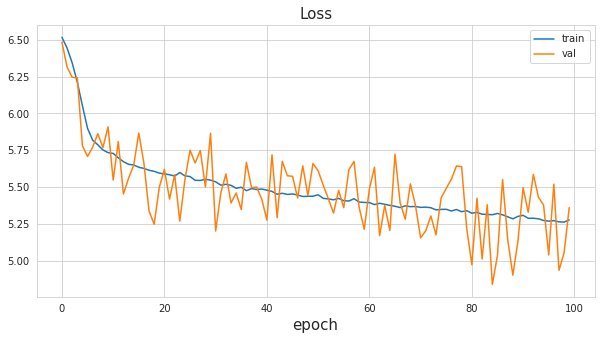

In [23]:
#model with batches rus-eng

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:   1%|          | 1/100 [00:04<07:11,  4.36s/it]

Epoch train loss 6.554988169670105
Epoch val_loss 6.509219169616699



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

epochs:   2%|▏         | 2/100 [00:08<07:07,  4.36s/it]

Epoch train loss 6.499423885345459
Epoch val_loss 6.4500017166137695



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:   3%|▎         | 3/100 [00:13<07:04,  4.37s/it]

Epoch train loss 6.427316355705261
Epoch val_loss 6.472189903259277



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:   4%|▍         | 4/100 [00:17<06:57,  4.35s/it]

Epoch train loss 6.343217754364014
Epoch val_loss 6.379801273345947



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

epochs:   5%|▌         | 5/100 [00:21<06:50,  4.32s/it]

Epoch train loss 6.223815560340881
Epoch val_loss 6.120441913604736



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

epochs:   6%|▌         | 6/100 [00:25<06:43,  4.30s/it]

Epoch train loss 6.079048013687133
Epoch val_loss 6.053910732269287



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:   7%|▋         | 7/100 [00:30<06:40,  4.31s/it]

Epoch train loss 5.936642694473266
Epoch val_loss 5.6660261154174805



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:   8%|▊         | 8/100 [00:34<06:35,  4.30s/it]

Epoch train loss 5.881429648399353
Epoch val_loss 5.8893609046936035



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:   9%|▉         | 9/100 [00:38<06:31,  4.30s/it]

Epoch train loss 5.844079613685608
Epoch val_loss 5.879275798797607



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  10%|█         | 10/100 [00:43<06:27,  4.30s/it]

Epoch train loss 5.826182556152344
Epoch val_loss 5.973962306976318



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

epochs:  11%|█         | 11/100 [00:47<06:24,  4.32s/it]

Epoch train loss 5.80567774772644
Epoch val_loss 5.87179708480835



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  12%|█▏        | 12/100 [00:51<06:21,  4.34s/it]

Epoch train loss 5.781059622764587
Epoch val_loss 5.936374664306641



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  13%|█▎        | 13/100 [00:56<06:17,  4.34s/it]

Epoch train loss 5.758055520057678
Epoch val_loss 5.894413948059082



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  14%|█▍        | 14/100 [01:00<06:11,  4.32s/it]

Epoch train loss 5.736885237693786
Epoch val_loss 5.6281819343566895



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  15%|█▌        | 15/100 [01:04<06:07,  4.33s/it]

Epoch train loss 5.736794400215149
Epoch val_loss 5.897131443023682



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

epochs:  16%|█▌        | 16/100 [01:09<06:02,  4.32s/it]

Epoch train loss 5.714127683639527
Epoch val_loss 5.580977916717529



train sample batches: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]

epochs:  17%|█▋        | 17/100 [01:14<06:30,  4.71s/it]

Epoch train loss 5.688987827301025
Epoch val_loss 5.724976539611816



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:  18%|█▊        | 18/100 [01:19<06:15,  4.58s/it]

Epoch train loss 5.6857915163040165
Epoch val_loss 5.634098529815674



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]

epochs:  19%|█▉        | 19/100 [01:23<06:03,  4.48s/it]

Epoch train loss 5.662241148948669
Epoch val_loss 5.602914333343506



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

epochs:  20%|██        | 20/100 [01:27<05:52,  4.41s/it]

Epoch train loss 5.655105400085449
Epoch val_loss 5.5449981689453125



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  21%|██        | 21/100 [01:31<05:46,  4.39s/it]

Epoch train loss 5.6476847410202025
Epoch val_loss 5.667754650115967



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  22%|██▏       | 22/100 [01:36<05:40,  4.36s/it]

Epoch train loss 5.621837377548218
Epoch val_loss 5.628544807434082



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  23%|██▎       | 23/100 [01:40<05:34,  4.34s/it]

Epoch train loss 5.618307733535767
Epoch val_loss 5.636109828948975



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  24%|██▍       | 24/100 [01:44<05:29,  4.34s/it]

Epoch train loss 5.617402338981629
Epoch val_loss 5.636711597442627



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  25%|██▌       | 25/100 [01:49<05:25,  4.34s/it]

Epoch train loss 5.616051244735718
Epoch val_loss 5.7562785148620605



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  26%|██▌       | 26/100 [01:53<05:19,  4.32s/it]

Epoch train loss 5.587627196311951
Epoch val_loss 5.414174556732178



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  27%|██▋       | 27/100 [01:57<05:14,  4.31s/it]

Epoch train loss 5.576003670692444
Epoch val_loss 5.464822292327881



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  28%|██▊       | 28/100 [02:02<05:10,  4.31s/it]

Epoch train loss 5.579515552520752
Epoch val_loss 5.41224479675293



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  29%|██▉       | 29/100 [02:06<05:05,  4.31s/it]

Epoch train loss 5.568720984458923
Epoch val_loss 5.690887451171875



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  30%|███       | 30/100 [02:10<05:02,  4.32s/it]

Epoch train loss 5.562990260124207
Epoch val_loss 5.816835880279541



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]

epochs:  31%|███       | 31/100 [02:14<04:56,  4.30s/it]

Epoch train loss 5.554143857955933
Epoch val_loss 5.559301853179932



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  32%|███▏      | 32/100 [02:19<04:53,  4.31s/it]

Epoch train loss 5.5533984184265135
Epoch val_loss 5.630687713623047



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

epochs:  33%|███▎      | 33/100 [02:23<04:48,  4.31s/it]

Epoch train loss 5.535632300376892
Epoch val_loss 5.639522075653076



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  34%|███▍      | 34/100 [02:27<04:45,  4.32s/it]

Epoch train loss 5.525870299339294
Epoch val_loss 5.412332534790039



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

epochs:  35%|███▌      | 35/100 [02:32<04:41,  4.32s/it]

Epoch train loss 5.527950716018677
Epoch val_loss 5.242859363555908



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  36%|███▌      | 36/100 [02:36<04:37,  4.34s/it]

Epoch train loss 5.509857988357544
Epoch val_loss 5.538730144500732



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  37%|███▋      | 37/100 [02:40<04:33,  4.34s/it]

Epoch train loss 5.504852509498596
Epoch val_loss 5.567864418029785



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

epochs:  38%|███▊      | 38/100 [02:45<04:29,  4.34s/it]

Epoch train loss 5.495302224159241
Epoch val_loss 4.996547222137451



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  39%|███▉      | 39/100 [02:49<04:23,  4.32s/it]

Epoch train loss 5.499797344207764
Epoch val_loss 5.5139946937561035



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  40%|████      | 40/100 [02:53<04:18,  4.31s/it]

Epoch train loss 5.488918709754944
Epoch val_loss 5.554884910583496



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]

epochs:  41%|████      | 41/100 [02:58<04:13,  4.30s/it]

Epoch train loss 5.4851425886154175
Epoch val_loss 5.349232196807861



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

epochs:  42%|████▏     | 42/100 [03:02<04:08,  4.29s/it]

Epoch train loss 5.462452006340027
Epoch val_loss 5.155623912811279



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]

epochs:  43%|████▎     | 43/100 [03:06<04:03,  4.28s/it]

Epoch train loss 5.466956901550293
Epoch val_loss 5.74457311630249



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]

epochs:  44%|████▍     | 44/100 [03:10<03:58,  4.26s/it]

Epoch train loss 5.474020290374756
Epoch val_loss 5.667248249053955



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  45%|████▌     | 45/100 [03:15<03:55,  4.28s/it]

Epoch train loss 5.467810249328613
Epoch val_loss 5.560577869415283



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

epochs:  46%|████▌     | 46/100 [03:19<03:50,  4.27s/it]

Epoch train loss 5.468422627449035
Epoch val_loss 5.747562885284424



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

epochs:  47%|████▋     | 47/100 [03:23<03:45,  4.26s/it]

Epoch train loss 5.461954021453858
Epoch val_loss 5.311671733856201



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

epochs:  48%|████▊     | 48/100 [03:27<03:41,  4.25s/it]

Epoch train loss 5.438479995727539
Epoch val_loss 5.2476043701171875



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]

epochs:  49%|████▉     | 49/100 [03:32<03:38,  4.28s/it]

Epoch train loss 5.434009265899658
Epoch val_loss 5.153692722320557



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  50%|█████     | 50/100 [03:36<03:35,  4.30s/it]

Epoch train loss 5.418323659896851
Epoch val_loss 5.750725269317627



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:  51%|█████     | 51/100 [03:40<03:31,  4.31s/it]

Epoch train loss 5.441932511329651
Epoch val_loss 5.595475196838379



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:  52%|█████▏    | 52/100 [03:45<03:28,  4.34s/it]

Epoch train loss 5.4320701360702515
Epoch val_loss 5.594936370849609



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]

epochs:  53%|█████▎    | 53/100 [03:49<03:24,  4.35s/it]

Epoch train loss 5.435267066955566
Epoch val_loss 5.578449249267578



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]

epochs:  54%|█████▍    | 54/100 [03:54<03:19,  4.33s/it]

Epoch train loss 5.424959826469421
Epoch val_loss 5.667141914367676



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  55%|█████▌    | 55/100 [03:58<03:14,  4.32s/it]

Epoch train loss 5.400750756263733
Epoch val_loss 5.456635475158691



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  56%|█████▌    | 56/100 [04:02<03:10,  4.33s/it]

Epoch train loss 5.43097140789032
Epoch val_loss 5.605527400970459



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

epochs:  57%|█████▋    | 57/100 [04:06<03:05,  4.32s/it]

Epoch train loss 5.408387470245361
Epoch val_loss 5.527034759521484



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

epochs:  58%|█████▊    | 58/100 [04:11<03:00,  4.29s/it]

Epoch train loss 5.405206823348999
Epoch val_loss 5.46926736831665



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

epochs:  59%|█████▉    | 59/100 [04:15<02:55,  4.29s/it]

Epoch train loss 5.4133223533630375
Epoch val_loss 5.391340255737305



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  60%|██████    | 60/100 [04:19<02:52,  4.30s/it]

Epoch train loss 5.405083250999451
Epoch val_loss 5.297643184661865



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]

epochs:  61%|██████    | 61/100 [04:24<02:47,  4.29s/it]

Epoch train loss 5.3840800523757935
Epoch val_loss 5.365136623382568



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

epochs:  62%|██████▏   | 62/100 [04:28<02:43,  4.30s/it]

Epoch train loss 5.3876553773880005
Epoch val_loss 5.425618648529053



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s]

epochs:  63%|██████▎   | 63/100 [04:32<02:38,  4.27s/it]

Epoch train loss 5.386449670791626
Epoch val_loss 5.255518436431885



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  64%|██████▍   | 64/100 [04:36<02:34,  4.28s/it]

Epoch train loss 5.391722702980042
Epoch val_loss 5.452656269073486



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:  65%|██████▌   | 65/100 [04:41<02:30,  4.29s/it]

Epoch train loss 5.377429723739624
Epoch val_loss 5.2984795570373535



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

epochs:  66%|██████▌   | 66/100 [04:45<02:25,  4.28s/it]

Epoch train loss 5.381964778900146
Epoch val_loss 5.564269065856934



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  67%|██████▋   | 67/100 [04:49<02:22,  4.31s/it]

Epoch train loss 5.388525676727295
Epoch val_loss 5.349618911743164



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

epochs:  68%|██████▊   | 68/100 [04:54<02:17,  4.31s/it]

Epoch train loss 5.379276514053345
Epoch val_loss 5.370521068572998



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]

epochs:  69%|██████▉   | 69/100 [04:58<02:13,  4.30s/it]

Epoch train loss 5.367103362083435
Epoch val_loss 5.267470836639404



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  70%|███████   | 70/100 [05:02<02:09,  4.32s/it]

Epoch train loss 5.359594202041626
Epoch val_loss 5.459521293640137



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]

epochs:  71%|███████   | 71/100 [05:07<02:05,  4.31s/it]

Epoch train loss 5.359339737892151
Epoch val_loss 5.576589584350586



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  72%|███████▏  | 72/100 [05:11<02:01,  4.32s/it]

Epoch train loss 5.36670138835907
Epoch val_loss 5.374125957489014



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]

epochs:  73%|███████▎  | 73/100 [05:15<01:56,  4.31s/it]

Epoch train loss 5.360119771957398
Epoch val_loss 5.1813883781433105



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  74%|███████▍  | 74/100 [05:20<01:52,  4.33s/it]

Epoch train loss 5.355377817153931
Epoch val_loss 5.4828338623046875



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  75%|███████▌  | 75/100 [05:24<01:48,  4.34s/it]

Epoch train loss 5.334323573112488
Epoch val_loss 5.380649566650391



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  76%|███████▌  | 76/100 [05:28<01:44,  4.35s/it]

Epoch train loss 5.325169920921326
Epoch val_loss 5.704280853271484



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  77%|███████▋  | 77/100 [05:33<01:40,  4.37s/it]

Epoch train loss 5.337305307388306
Epoch val_loss 5.121983528137207



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  78%|███████▊  | 78/100 [05:37<01:35,  4.35s/it]

Epoch train loss 5.35061194896698
Epoch val_loss 4.827453136444092



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:  79%|███████▉  | 79/100 [05:41<01:31,  4.34s/it]

Epoch train loss 5.333179330825805
Epoch val_loss 5.588017463684082



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.04it/s]

epochs:  80%|████████  | 80/100 [05:46<01:27,  4.38s/it]

Epoch train loss 5.3302887916564945
Epoch val_loss 5.423541069030762



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  81%|████████  | 81/100 [05:50<01:23,  4.38s/it]

Epoch train loss 5.330653333663941
Epoch val_loss 5.2255096435546875



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:  82%|████████▏ | 82/100 [05:55<01:18,  4.37s/it]

Epoch train loss 5.309102988243103
Epoch val_loss 5.339055061340332



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  83%|████████▎ | 83/100 [05:59<01:14,  4.38s/it]

Epoch train loss 5.3174148321151735
Epoch val_loss 5.448272705078125



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  84%|████████▍ | 84/100 [06:03<01:10,  4.40s/it]

Epoch train loss 5.317092514038086
Epoch val_loss 5.414456367492676



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  85%|████████▌ | 85/100 [06:08<01:05,  4.38s/it]

Epoch train loss 5.312966132164002
Epoch val_loss 5.455444812774658



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  86%|████████▌ | 86/100 [06:12<01:01,  4.38s/it]

Epoch train loss 5.32162115573883
Epoch val_loss 5.660843372344971



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  87%|████████▋ | 87/100 [06:16<00:56,  4.36s/it]

Epoch train loss 5.323707509040832
Epoch val_loss 5.473751544952393



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  88%|████████▊ | 88/100 [06:21<00:52,  4.39s/it]

Epoch train loss 5.313674139976501
Epoch val_loss 5.28843879699707



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  89%|████████▉ | 89/100 [06:25<00:48,  4.38s/it]

Epoch train loss 5.3050037860870365
Epoch val_loss 5.19980525970459



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]

epochs:  90%|█████████ | 90/100 [06:30<00:43,  4.39s/it]

Epoch train loss 5.30885694026947
Epoch val_loss 5.570155620574951



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:  91%|█████████ | 91/100 [06:34<00:39,  4.40s/it]

Epoch train loss 5.293866300582886
Epoch val_loss 5.226130962371826



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  92%|█████████▏| 92/100 [06:38<00:35,  4.38s/it]

Epoch train loss 5.2862978219985965
Epoch val_loss 5.668463706970215



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:  93%|█████████▎| 93/100 [06:43<00:30,  4.41s/it]

Epoch train loss 5.2818560123443605
Epoch val_loss 4.942965507507324



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  94%|█████████▍| 94/100 [06:47<00:26,  4.44s/it]

Epoch train loss 5.283236074447632
Epoch val_loss 5.348710060119629



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  95%|█████████▌| 95/100 [06:52<00:22,  4.49s/it]

Epoch train loss 5.297665071487427
Epoch val_loss 5.245044231414795



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

epochs:  96%|█████████▌| 96/100 [06:57<00:18,  4.53s/it]

Epoch train loss 5.268844056129455
Epoch val_loss 5.1827073097229



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  97%|█████████▋| 97/100 [07:01<00:13,  4.54s/it]

Epoch train loss 5.270499992370605
Epoch val_loss 5.33510160446167



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

epochs:  98%|█████████▊| 98/100 [07:06<00:09,  4.57s/it]

Epoch train loss 5.275571990013122
Epoch val_loss 4.760276794433594



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

epochs:  99%|█████████▉| 99/100 [07:10<00:04,  4.57s/it]

Epoch train loss 5.270645165443421
Epoch val_loss 5.276698589324951



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

epochs: 100%|██████████| 100/100 [07:15<00:00,  4.35s/it]


Epoch train loss 5.263022494316101
Epoch val_loss 5.200659275054932


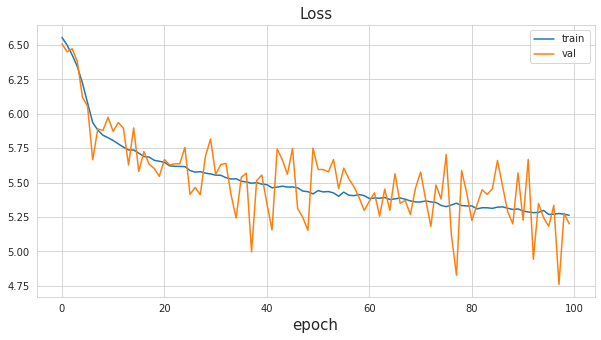

In [16]:
#model with batches rus-eng

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

Result is not good. Model is not learn and validation loss has big spread. Spread of valodate loss is increasing doe to epochs.
I try to use other Loss function:CrossEntropyLoss

train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:   1%|          | 1/100 [00:04<07:17,  4.42s/it]

Epoch train loss 6.552566695213318
Epoch val_loss 6.541161060333252



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:   2%|▏         | 2/100 [00:08<07:14,  4.44s/it]

Epoch train loss 6.499226236343384
Epoch val_loss 6.423122882843018



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]

epochs:   3%|▎         | 3/100 [00:13<07:08,  4.42s/it]

Epoch train loss 6.429273509979248
Epoch val_loss 6.388733386993408



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:   4%|▍         | 4/100 [00:17<07:02,  4.40s/it]

Epoch train loss 6.34425950050354
Epoch val_loss 6.13942813873291



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:   5%|▌         | 5/100 [00:22<06:57,  4.39s/it]

Epoch train loss 6.237201476097107
Epoch val_loss 6.177688121795654



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:   6%|▌         | 6/100 [00:26<06:55,  4.42s/it]

Epoch train loss 6.096936964988709
Epoch val_loss 5.9016194343566895



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:   7%|▋         | 7/100 [00:30<06:50,  4.41s/it]

Epoch train loss 5.967418313026428
Epoch val_loss 5.660855770111084



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]

epochs:   8%|▊         | 8/100 [00:35<06:44,  4.40s/it]

Epoch train loss 5.881306910514832
Epoch val_loss 5.570796966552734



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:   9%|▉         | 9/100 [00:39<06:38,  4.37s/it]

Epoch train loss 5.857645487785339
Epoch val_loss 5.665077209472656



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.04it/s]

epochs:  10%|█         | 10/100 [00:44<06:35,  4.40s/it]

Epoch train loss 5.8350280046463014
Epoch val_loss 5.793271541595459



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  11%|█         | 11/100 [00:48<06:29,  4.37s/it]

Epoch train loss 5.804476308822632
Epoch val_loss 5.605051040649414



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  12%|█▏        | 12/100 [00:52<06:25,  4.38s/it]

Epoch train loss 5.78564031124115
Epoch val_loss 5.549324035644531



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  13%|█▎        | 13/100 [00:57<06:22,  4.39s/it]

Epoch train loss 5.773302888870239
Epoch val_loss 5.783725261688232



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  14%|█▍        | 14/100 [01:01<06:15,  4.36s/it]

Epoch train loss 5.73897500038147
Epoch val_loss 5.590060234069824



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

epochs:  15%|█▌        | 15/100 [01:05<06:10,  4.36s/it]

Epoch train loss 5.7219446182250975
Epoch val_loss 5.881548881530762



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  16%|█▌        | 16/100 [01:10<06:09,  4.39s/it]

Epoch train loss 5.708237600326538
Epoch val_loss 5.4738287925720215



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  17%|█▋        | 17/100 [01:14<06:05,  4.41s/it]

Epoch train loss 5.700518202781677
Epoch val_loss 5.797557353973389



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  18%|█▊        | 18/100 [01:19<06:01,  4.41s/it]

Epoch train loss 5.683193612098694
Epoch val_loss 5.476178169250488



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  19%|█▉        | 19/100 [01:23<05:56,  4.40s/it]

Epoch train loss 5.668140268325805
Epoch val_loss 5.878017425537109



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  20%|██        | 20/100 [01:27<05:52,  4.40s/it]

Epoch train loss 5.653623557090759
Epoch val_loss 5.355998516082764



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  21%|██        | 21/100 [01:32<05:48,  4.42s/it]

Epoch train loss 5.64432213306427
Epoch val_loss 5.6872663497924805



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  22%|██▏       | 22/100 [01:36<05:43,  4.40s/it]

Epoch train loss 5.652153253555298
Epoch val_loss 5.494699954986572



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  23%|██▎       | 23/100 [01:41<05:38,  4.40s/it]

Epoch train loss 5.644750332832336
Epoch val_loss 5.482883453369141



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

epochs:  24%|██▍       | 24/100 [01:45<05:36,  4.43s/it]

Epoch train loss 5.625010514259339
Epoch val_loss 5.568750858306885



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  25%|██▌       | 25/100 [01:50<05:31,  4.42s/it]

Epoch train loss 5.617369818687439
Epoch val_loss 5.6634650230407715



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

epochs:  26%|██▌       | 26/100 [01:54<05:26,  4.41s/it]

Epoch train loss 5.603300929069519
Epoch val_loss 5.450275421142578



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  27%|██▋       | 27/100 [01:58<05:21,  4.40s/it]

Epoch train loss 5.610483193397522
Epoch val_loss 5.386950969696045



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  28%|██▊       | 28/100 [02:03<05:17,  4.41s/it]

Epoch train loss 5.591124796867371
Epoch val_loss 5.718270778656006



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

epochs:  29%|██▉       | 29/100 [02:07<05:15,  4.45s/it]

Epoch train loss 5.58066840171814
Epoch val_loss 5.697366237640381



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  30%|███       | 30/100 [02:12<05:13,  4.47s/it]

Epoch train loss 5.567025470733642
Epoch val_loss 5.497506618499756



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

epochs:  31%|███       | 31/100 [02:16<05:06,  4.45s/it]

Epoch train loss 5.560909581184387
Epoch val_loss 5.690648078918457



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  32%|███▏      | 32/100 [02:21<05:04,  4.48s/it]

Epoch train loss 5.544739484786987
Epoch val_loss 5.571104049682617



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  33%|███▎      | 33/100 [02:25<05:01,  4.50s/it]

Epoch train loss 5.543087339401245
Epoch val_loss 5.44691801071167



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  34%|███▍      | 34/100 [02:30<04:59,  4.53s/it]

Epoch train loss 5.541494655609131
Epoch val_loss 5.615663051605225



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  35%|███▌      | 35/100 [02:34<04:55,  4.55s/it]

Epoch train loss 5.526002907752991
Epoch val_loss 5.185295104980469



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

epochs:  36%|███▌      | 36/100 [02:39<04:52,  4.58s/it]

Epoch train loss 5.51267511844635
Epoch val_loss 5.568811893463135



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]

epochs:  37%|███▋      | 37/100 [02:44<04:47,  4.57s/it]

Epoch train loss 5.518103218078613
Epoch val_loss 5.558389186859131



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  38%|███▊      | 38/100 [02:48<04:43,  4.57s/it]

Epoch train loss 5.515157723426819
Epoch val_loss 5.424283504486084



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

epochs:  39%|███▉      | 39/100 [02:53<04:38,  4.57s/it]

Epoch train loss 5.512111616134644
Epoch val_loss 5.844587326049805



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]

epochs:  40%|████      | 40/100 [02:57<04:35,  4.59s/it]

Epoch train loss 5.488104081153869
Epoch val_loss 5.427387714385986



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

epochs:  41%|████      | 41/100 [03:02<04:31,  4.61s/it]

Epoch train loss 5.4877582550048825
Epoch val_loss 5.4206342697143555



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]

epochs:  42%|████▏     | 42/100 [03:07<04:25,  4.57s/it]

Epoch train loss 5.48721718788147
Epoch val_loss 5.199917793273926



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

epochs:  43%|████▎     | 43/100 [03:11<04:21,  4.59s/it]

Epoch train loss 5.490316486358642
Epoch val_loss 5.391596794128418



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

epochs:  44%|████▍     | 44/100 [03:16<04:15,  4.56s/it]

Epoch train loss 5.488300228118897
Epoch val_loss 5.491133213043213



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  45%|████▌     | 45/100 [03:20<04:09,  4.54s/it]

Epoch train loss 5.4692976713180546
Epoch val_loss 5.455318450927734



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

epochs:  46%|████▌     | 46/100 [03:25<04:05,  4.55s/it]

Epoch train loss 5.459509992599488
Epoch val_loss 5.218785285949707



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

epochs:  47%|████▋     | 47/100 [03:29<04:01,  4.56s/it]

Epoch train loss 5.476394939422607
Epoch val_loss 5.791028022766113



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  48%|████▊     | 48/100 [03:34<03:56,  4.55s/it]

Epoch train loss 5.451833176612854
Epoch val_loss 5.278819561004639



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]

epochs:  49%|████▉     | 49/100 [03:39<03:55,  4.62s/it]

Epoch train loss 5.442450547218323
Epoch val_loss 5.588882923126221



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s]

epochs:  50%|█████     | 50/100 [03:43<03:51,  4.64s/it]

Epoch train loss 5.446424961090088
Epoch val_loss 5.392282962799072



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

epochs:  51%|█████     | 51/100 [03:48<03:47,  4.64s/it]

Epoch train loss 5.440798926353454
Epoch val_loss 5.666738986968994



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]

epochs:  52%|█████▏    | 52/100 [03:53<03:42,  4.64s/it]

Epoch train loss 5.443167662620544
Epoch val_loss 5.367361068725586



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  53%|█████▎    | 53/100 [03:57<03:37,  4.62s/it]

Epoch train loss 5.432713603973388
Epoch val_loss 5.121006488800049



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  54%|█████▍    | 54/100 [04:02<03:32,  4.61s/it]

Epoch train loss 5.441093444824219
Epoch val_loss 5.279427528381348



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

epochs:  55%|█████▌    | 55/100 [04:06<03:27,  4.62s/it]

Epoch train loss 5.423575115203858
Epoch val_loss 5.1721038818359375



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  56%|█████▌    | 56/100 [04:11<03:21,  4.57s/it]

Epoch train loss 5.428444027900696
Epoch val_loss 5.2327189445495605



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s]

epochs:  57%|█████▋    | 57/100 [04:16<03:18,  4.61s/it]

Epoch train loss 5.428913354873657
Epoch val_loss 5.5067925453186035



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  58%|█████▊    | 58/100 [04:20<03:12,  4.59s/it]

Epoch train loss 5.415629410743714
Epoch val_loss 5.311938762664795



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  59%|█████▉    | 59/100 [04:25<03:05,  4.53s/it]

Epoch train loss 5.407843089103698
Epoch val_loss 5.298851490020752



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  60%|██████    | 60/100 [04:29<03:01,  4.53s/it]

Epoch train loss 5.412167954444885
Epoch val_loss 5.4154205322265625



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  61%|██████    | 61/100 [04:33<02:55,  4.50s/it]

Epoch train loss 5.40780622959137
Epoch val_loss 5.561909198760986



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  62%|██████▏   | 62/100 [04:38<02:51,  4.51s/it]

Epoch train loss 5.409027695655823
Epoch val_loss 5.522075653076172



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  63%|██████▎   | 63/100 [04:43<02:47,  4.52s/it]

Epoch train loss 5.399421739578247
Epoch val_loss 5.4178385734558105



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

epochs:  64%|██████▍   | 64/100 [04:47<02:42,  4.50s/it]

Epoch train loss 5.405531930923462
Epoch val_loss 5.151031970977783



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  65%|██████▌   | 65/100 [04:51<02:36,  4.47s/it]

Epoch train loss 5.403483152389526
Epoch val_loss 5.20932674407959



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  66%|██████▌   | 66/100 [04:56<02:32,  4.48s/it]

Epoch train loss 5.387399911880493
Epoch val_loss 5.32880973815918



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  67%|██████▋   | 67/100 [05:00<02:27,  4.47s/it]

Epoch train loss 5.391401529312134
Epoch val_loss 5.379230976104736



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.04it/s]

epochs:  68%|██████▊   | 68/100 [05:05<02:23,  4.47s/it]

Epoch train loss 5.374852967262268
Epoch val_loss 5.60361909866333



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  69%|██████▉   | 69/100 [05:09<02:19,  4.49s/it]

Epoch train loss 5.3772313594818115
Epoch val_loss 5.143773555755615



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  70%|███████   | 70/100 [05:14<02:14,  4.47s/it]

Epoch train loss 5.383737993240357
Epoch val_loss 5.607964515686035



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  71%|███████   | 71/100 [05:18<02:09,  4.47s/it]

Epoch train loss 5.370519971847534
Epoch val_loss 5.595300197601318



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  72%|███████▏  | 72/100 [05:23<02:05,  4.47s/it]

Epoch train loss 5.3857861995697025
Epoch val_loss 5.436459541320801



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  73%|███████▎  | 73/100 [05:27<02:00,  4.46s/it]

Epoch train loss 5.373042130470276
Epoch val_loss 5.1240057945251465



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  74%|███████▍  | 74/100 [05:32<01:55,  4.45s/it]

Epoch train loss 5.36241648197174
Epoch val_loss 5.313450813293457



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]

epochs:  75%|███████▌  | 75/100 [05:36<01:50,  4.41s/it]

Epoch train loss 5.364980220794678
Epoch val_loss 5.347035884857178



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  76%|███████▌  | 76/100 [05:40<01:45,  4.40s/it]

Epoch train loss 5.364061069488526
Epoch val_loss 5.396629810333252



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  77%|███████▋  | 77/100 [05:45<01:41,  4.42s/it]

Epoch train loss 5.3721322298049925
Epoch val_loss 5.272468566894531



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  78%|███████▊  | 78/100 [05:49<01:37,  4.43s/it]

Epoch train loss 5.340686297416687
Epoch val_loss 5.260862827301025



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  79%|███████▉  | 79/100 [05:54<01:33,  4.46s/it]

Epoch train loss 5.364559054374695
Epoch val_loss 5.567112445831299



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  80%|████████  | 80/100 [05:58<01:29,  4.49s/it]

Epoch train loss 5.351738691329956
Epoch val_loss 5.658279895782471



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  81%|████████  | 81/100 [06:03<01:24,  4.45s/it]

Epoch train loss 5.363102626800537
Epoch val_loss 5.494990825653076



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  82%|████████▏ | 82/100 [06:07<01:20,  4.45s/it]

Epoch train loss 5.344273495674133
Epoch val_loss 5.383716106414795



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  83%|████████▎ | 83/100 [06:12<01:16,  4.48s/it]

Epoch train loss 5.337773680686951
Epoch val_loss 5.357541561126709



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  84%|████████▍ | 84/100 [06:16<01:11,  4.49s/it]

Epoch train loss 5.337178301811218
Epoch val_loss 5.395554542541504



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  85%|████████▌ | 85/100 [06:21<01:07,  4.48s/it]

Epoch train loss 5.333296585083008
Epoch val_loss 5.6234517097473145



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  86%|████████▌ | 86/100 [06:25<01:02,  4.46s/it]

Epoch train loss 5.320566082000733
Epoch val_loss 4.827795028686523



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  87%|████████▋ | 87/100 [06:30<00:58,  4.47s/it]

Epoch train loss 5.315337347984314
Epoch val_loss 5.118821144104004



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  88%|████████▊ | 88/100 [06:34<00:53,  4.48s/it]

Epoch train loss 5.3191464185714725
Epoch val_loss 5.372116565704346



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  89%|████████▉ | 89/100 [06:39<00:49,  4.47s/it]

Epoch train loss 5.32042498588562
Epoch val_loss 5.544614791870117



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

epochs:  90%|█████████ | 90/100 [06:43<00:45,  4.52s/it]

Epoch train loss 5.310951232910156
Epoch val_loss 5.045040607452393



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

epochs:  91%|█████████ | 91/100 [06:48<00:41,  4.56s/it]

Epoch train loss 5.314847135543824
Epoch val_loss 5.430896759033203



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.04it/s]

epochs:  92%|█████████▏| 92/100 [06:52<00:36,  4.54s/it]

Epoch train loss 5.305624604225159
Epoch val_loss 5.431525707244873



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s]

epochs:  93%|█████████▎| 93/100 [06:57<00:32,  4.60s/it]

Epoch train loss 5.279518985748291
Epoch val_loss 4.6670756340026855



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  94%|█████████▍| 94/100 [07:02<00:27,  4.61s/it]

Epoch train loss 5.3072953701019285
Epoch val_loss 5.173975467681885



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  95%|█████████▌| 95/100 [07:06<00:22,  4.59s/it]

Epoch train loss 5.301408410072327
Epoch val_loss 5.3068413734436035



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

epochs:  96%|█████████▌| 96/100 [07:11<00:18,  4.60s/it]

Epoch train loss 5.292515897750855
Epoch val_loss 5.375654697418213



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

epochs:  97%|█████████▋| 97/100 [07:15<00:13,  4.57s/it]

Epoch train loss 5.290646815299988
Epoch val_loss 5.200448989868164



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  98%|█████████▊| 98/100 [07:20<00:09,  4.58s/it]

Epoch train loss 5.292220711708069
Epoch val_loss 5.110963821411133



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

epochs:  99%|█████████▉| 99/100 [07:24<00:04,  4.57s/it]

Epoch train loss 5.294781970977783
Epoch val_loss 5.475249290466309



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

epochs: 100%|██████████| 100/100 [07:29<00:00,  4.50s/it]


Epoch train loss 5.288036179542542
Epoch val_loss 5.472621440887451


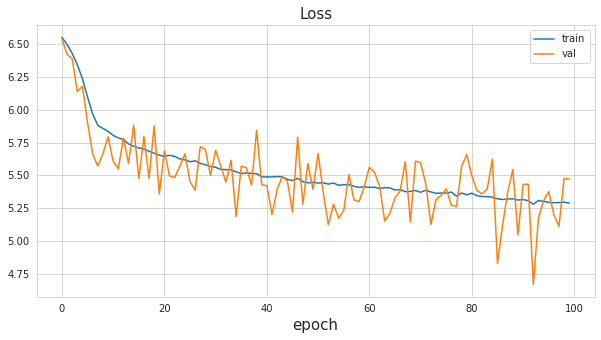

In [ ]:
#model with batches rus-eng

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'])
criterion = nn.CrossEntropyLoss(ignore_index = 0)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

Result is the same as in the previous time.

Let's look at the translation result and calculate metric. 

In [40]:
#from torchtext.data.metrics import bleu_score 

In [24]:
from nltk.translate.bleu_score import sentence_bleu

In [41]:
def evaluateRandomly(model, pairs, input_lang, output_lang, n=10):
    for i in range(n):
        outputs=[]
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        input_tensor = tensorFromSentence(input_lang, pair[0], config['MAX_LENGTH'])
        input_len=torch.tensor([len(pair[0].split(' '))], dtype=torch.int64)
        target_tensor=tensorFromSentence(output_lang, pair[1], config['MAX_LENGTH'])
                
        output_words, _ = model(input_tensor.reshape(1,20), input_len, target_tensor.reshape(1,20), evalute=True)    
        
        result=output_words.argmax(2).detach()
        result=result.squeeze(0)
        
        for idx in range(result.shape[0]):
            tok=train_output_lang.index2word[result[idx].item()]
            if tok=='EOS':
              break
            outputs.append(tok) 
        #print(bleu_score(result.tolist(), target_tensor.tolist()))      
        output_sentence = ' '.join(outputs)
        print('<', output_sentence)
        print('')
        
        print('Blue score of this sentence  - ', sentence_bleu(outputs, pair[1].split(' ')))
        print('')
        print('======================================')

In [28]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang, n=1)

> и питьемь 
= и питьем 
< и  и 

Blue score of this sentence  -  0.7598356856515925



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [29]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang)

> и питьемь 
= и питьем 
< и  и 

Blue score of this sentence  -  0.7598356856515925

> ино надобѣ всякомy человѣкy тъщеславия бѣгати и похвалы 
= ибо следует каждому человеку избегать тщеславия  и похвал 
< и и и и и и и   и 

Blue score of this sentence  -  0.5623413251903491

> въ нощи же слышахъ  яко врата домy моего отверзошасѧ 
= ночью же я услышал  как ворота моего дома отворились 
< и и и    и и и   

Blue score of this sentence  -  0

> дъва рождениѣ соуть 
= то это два рождения 
< и и   и 

Blue score of this sentence  -  0

> таковыи подобенъ оплотy беӡъ подпоръ стоящю:
= то такои подобен стене  без подпор стоящеи:
< и        

Blue score of this sentence  -  0

> видѣвъ я  оуноша радъ бывъ текъ поклони ся имъ и любьзно цѣлова я и въпроси я 
= увидев их  обрадовавшись  юноша  побежав  поклонился им  с любовью приветствовал их и спросил их 
< и                   

Blue score of this sentence  -  0.4728708045015879

> ѥще же гнѣвъмь одьржима соущи 
= но все еще будучи одержима

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


< и                   

Blue score of this sentence  -  0

> ѣдение и питие беӡъ говора съ удьржаниемь 
= еду питье (вкушать) в безмолвии с умеренностью 
< и                   

Blue score of this sentence  -  0

> тълкъ: ягда коурица родить ѣицо и высидить алекторы 
= ответ: когда курица снесет яицо и высидит цыпленка 
< и и и и и и  и и 

Blue score of this sentence  -  0.5773502691896257

> ти тако повелѣ ѥмоу ходити 
= и приказала так ходить 
< и                   

Blue score of this sentence  -  0.668740304976422



In [30]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang)

> а всѧкая обида со благодарениемъ терпѣти бога ради 
= всякую обиду с благодарностью претерпевать ради бога:
< и       и

Blue score of this sentence  -  0

> сие врачемъ любеӡно:
= это и у врачеи принято:
< и                   

Blue score of this sentence  -  0.668740304976422

> да аще бо погибнеть единъ ею 
= и если погибнет один из них 
< и                   

Blue score of this sentence  -  0.6147881529512643

> а противъ не мстити
= а в ответ не мстить 
< и и  и и и 

Blue score of this sentence  -  0

> выведоша новгородьци изъ пльскова ярослава ярославiча 
= вызвали новгородцы из пскова ярослава ярославича
< и      

Blue score of this sentence  -  0

> дроугъ вѣренъ съкровище доуховьно 
= верныи друг – это сокровище духа 
< и    и и  

Blue score of this sentence  -  0

> напоите накормите оyнеина
= напоите и накормите нищего 
< и     

Blue score of this sentence  -  0.668740304976422

> сие врачемъ любеӡно:
= это и у врачеи принято:


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


< и                   

Blue score of this sentence  -  0.668740304976422

> югъ
= ужин
< и                   

Blue score of this sentence  -  0

> то видока ему не искати 
= то ему не надо искать свидетеля 
< и                   

Blue score of this sentence  -  0



Not good result. Let's try to use embeddings from Word2Vec model.

First clean memory

In [89]:
import gc

gc.collect()

129

Create word embadings using Word2Vec

In [ ]:
from gensim.models import Word2Vec

collect all words from pairs

In [ ]:
def collect_all_words(pairs, source=True):
  if source:
    sent=[pair[0] for pair in pairs]
  else:
    sent=[pair[1] for pair in pairs]
  all_words=  [[word for word in s.split(' ')] for s in sent]
  return all_words
all_src=  collect_all_words(train_pairs, source=True)
all_trg=  collect_all_words(train_pairs, source=False)

Create W2V models for source and target

In [ ]:
w2v_model_src = Word2Vec(
    min_count=2,
    window=2,
    size=config['hidden_size'],
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)
w2v_model_trg = Word2Vec(
    min_count=2,
    window=2,
    size=config['hidden_size'],
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

Create vocabs for source and target

In [ ]:
w2v_model_src.build_vocab(all_src)
w2v_model_trg.build_vocab(all_trg)

Train models

In [ ]:
w2v_model_src.train(all_src, total_examples=w2v_model_src.corpus_count, epochs=30, report_delay=1)

(1237, 38370)

In [ ]:
w2v_model_trg.train(all_src, total_examples=w2v_model_trg.corpus_count, epochs=30, report_delay=1)

(539, 38370)

Save memory

In [ ]:
w2v_model_src.init_sims(replace=True)
w2v_model_trg.init_sims(replace=True)

Check numbers of words in vocabularies

In [ ]:
len(w2v_model_src.wv.vocab), len(w2v_model_trg.wv.vocab)

(101, 111)

Create embaddings for the words in vocabularies and out of vocabularies

In [ ]:
def get_weights(word2vec, vocab):
  mean = word2vec.wv.vectors.mean(1).mean()
  std = word2vec.wv.vectors.std(1).mean()
  vec_size = word2vec.wv.vector_size
  weights = torch.zeros((len(vocab)+2, vec_size))
  for i, word in enumerate(vocab):
    try:
      weights[i] = torch.tensor(word2vec.wv[word])
    except KeyError:
        weights[i] = torch.randn(vec_size) * std + mean
  weights[len(vocab)]  =torch.zeros(vec_size)  
  weights[len(vocab)]  =torch.ones(vec_size)  
  return   weights    

In [ ]:
weights_src=get_weights(w2v_model_src, train_input_lang.word2index.keys())
weights_trg=get_weights(w2v_model_trg, train_output_lang.word2index.keys())

Check shape of weights

In [ ]:
weights_src.shape, weights_trg.shape

(torch.Size([769, 256]), torch.Size([733, 256]))

Create embaddings

In [ ]:
embedding_src = nn.Embedding.from_pretrained(weights_src)
embedding_trg = nn.Embedding.from_pretrained(weights_trg)

Check embeddings shapes

In [ ]:
embedding_src, embedding_trg

(Embedding(769, 256), Embedding(733, 256))

I use these embeddings in model. Model needs some changes, to make model use given embeddings or create embeddings if not given.

train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:   1%|          | 1/100 [00:03<06:27,  3.92s/it]

Epoch train loss 6.596028685569763
Epoch val_loss 6.588851451873779



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:   2%|▏         | 2/100 [00:07<06:24,  3.92s/it]

Epoch train loss 6.5875465869903564
Epoch val_loss 6.584802627563477



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:   3%|▎         | 3/100 [00:11<06:20,  3.92s/it]

Epoch train loss 6.57952311038971
Epoch val_loss 6.574070930480957



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:   4%|▍         | 4/100 [00:15<06:17,  3.93s/it]

Epoch train loss 6.570721578598023
Epoch val_loss 6.560613632202148



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:   5%|▌         | 5/100 [00:19<06:14,  3.94s/it]

Epoch train loss 6.562531781196594
Epoch val_loss 6.555125713348389



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:   6%|▌         | 6/100 [00:23<06:11,  3.95s/it]

Epoch train loss 6.553736162185669
Epoch val_loss 6.543722629547119



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]

epochs:   7%|▋         | 7/100 [00:27<06:10,  3.99s/it]

Epoch train loss 6.544932961463928
Epoch val_loss 6.545968055725098



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]

epochs:   8%|▊         | 8/100 [00:31<06:08,  4.00s/it]

Epoch train loss 6.536847162246704
Epoch val_loss 6.521285533905029



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]

epochs:   9%|▉         | 9/100 [00:35<06:07,  4.04s/it]

Epoch train loss 6.5272263288497925
Epoch val_loss 6.5360636711120605



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  10%|█         | 10/100 [00:39<06:04,  4.05s/it]

Epoch train loss 6.519613432884216
Epoch val_loss 6.527033805847168



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

epochs:  11%|█         | 11/100 [00:44<06:03,  4.08s/it]

Epoch train loss 6.509893918037415
Epoch val_loss 6.504136562347412



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]

epochs:  12%|█▏        | 12/100 [00:48<06:00,  4.09s/it]

Epoch train loss 6.501270055770874
Epoch val_loss 6.501047134399414



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]

epochs:  13%|█▎        | 13/100 [00:52<05:55,  4.08s/it]

Epoch train loss 6.491538023948669
Epoch val_loss 6.491611957550049



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s]

epochs:  14%|█▍        | 14/100 [00:56<05:49,  4.06s/it]

Epoch train loss 6.483038520812988
Epoch val_loss 6.493992328643799



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

epochs:  15%|█▌        | 15/100 [01:00<05:46,  4.07s/it]

Epoch train loss 6.4745057106018065
Epoch val_loss 6.4992995262146



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  16%|█▌        | 16/100 [01:04<05:41,  4.07s/it]

Epoch train loss 6.4638916015625
Epoch val_loss 6.461095333099365



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]

epochs:  17%|█▋        | 17/100 [01:08<05:36,  4.05s/it]

Epoch train loss 6.453500080108642
Epoch val_loss 6.443894863128662



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs:  18%|█▊        | 18/100 [01:12<05:29,  4.02s/it]

Epoch train loss 6.442767405509949
Epoch val_loss 6.361841678619385



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  19%|█▉        | 19/100 [01:16<05:24,  4.01s/it]

Epoch train loss 6.4328878164291385
Epoch val_loss 6.424038887023926



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.60it/s]

epochs:  20%|██        | 20/100 [01:20<05:21,  4.01s/it]

Epoch train loss 6.423069667816162
Epoch val_loss 6.438797950744629



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]

epochs:  21%|██        | 21/100 [01:24<05:18,  4.03s/it]

Epoch train loss 6.4113239526748655
Epoch val_loss 6.402101039886475



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

epochs:  22%|██▏       | 22/100 [01:28<05:14,  4.03s/it]

Epoch train loss 6.40167543888092
Epoch val_loss 6.334565162658691



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:  23%|██▎       | 23/100 [01:32<05:08,  4.01s/it]

Epoch train loss 6.387799859046936
Epoch val_loss 6.448370456695557



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]

epochs:  24%|██▍       | 24/100 [01:36<05:04,  4.00s/it]

Epoch train loss 6.374383592605591
Epoch val_loss 6.353075981140137



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  25%|██▌       | 25/100 [01:40<04:59,  4.00s/it]

Epoch train loss 6.362960743904114
Epoch val_loss 6.3581013679504395



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]

epochs:  26%|██▌       | 26/100 [01:44<04:55,  4.00s/it]

Epoch train loss 6.352857327461242
Epoch val_loss 6.381657600402832



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

epochs:  27%|██▋       | 27/100 [01:48<04:53,  4.02s/it]

Epoch train loss 6.338783049583435
Epoch val_loss 6.381593227386475



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  28%|██▊       | 28/100 [01:52<04:49,  4.03s/it]

Epoch train loss 6.322348570823669
Epoch val_loss 6.389741897583008



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  29%|██▉       | 29/100 [01:56<04:47,  4.04s/it]

Epoch train loss 6.308847498893738
Epoch val_loss 6.330336570739746



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

epochs:  30%|███       | 30/100 [02:00<04:43,  4.05s/it]

Epoch train loss 6.290889406204224
Epoch val_loss 6.2159271240234375



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

epochs:  31%|███       | 31/100 [02:04<04:42,  4.09s/it]

Epoch train loss 6.275502228736878
Epoch val_loss 6.256630897521973



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]

epochs:  32%|███▏      | 32/100 [02:08<04:36,  4.07s/it]

Epoch train loss 6.256758713722229
Epoch val_loss 6.14119815826416



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  33%|███▎      | 33/100 [02:12<04:32,  4.06s/it]

Epoch train loss 6.238907647132874
Epoch val_loss 6.168822288513184



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  34%|███▍      | 34/100 [02:16<04:26,  4.04s/it]

Epoch train loss 6.221217632293701
Epoch val_loss 6.268754005432129



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  35%|███▌      | 35/100 [02:20<04:21,  4.03s/it]

Epoch train loss 6.200224757194519
Epoch val_loss 6.205676078796387



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  36%|███▌      | 36/100 [02:24<04:17,  4.02s/it]

Epoch train loss 6.178110265731812
Epoch val_loss 6.29073429107666



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]

epochs:  37%|███▋      | 37/100 [02:28<04:10,  3.98s/it]

Epoch train loss 6.155321931838989
Epoch val_loss 5.972084045410156



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  38%|███▊      | 38/100 [02:32<04:06,  3.98s/it]

Epoch train loss 6.129048991203308
Epoch val_loss 6.14007568359375



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]

epochs:  39%|███▉      | 39/100 [02:36<04:01,  3.97s/it]

Epoch train loss 6.101305413246155
Epoch val_loss 5.976349353790283



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]

epochs:  40%|████      | 40/100 [02:40<03:56,  3.95s/it]

Epoch train loss 6.076168775558472
Epoch val_loss 6.128569602966309



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  41%|████      | 41/100 [02:44<03:53,  3.95s/it]

Epoch train loss 6.047028350830078
Epoch val_loss 6.166954517364502



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]

epochs:  42%|████▏     | 42/100 [02:48<03:48,  3.93s/it]

Epoch train loss 6.0246293306350704
Epoch val_loss 6.130151271820068



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs:  43%|████▎     | 43/100 [02:52<03:44,  3.93s/it]

Epoch train loss 5.996199059486389
Epoch val_loss 5.925078868865967



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.83it/s]

epochs:  44%|████▍     | 44/100 [02:56<03:39,  3.92s/it]

Epoch train loss 5.9664109468460085
Epoch val_loss 6.030362129211426



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]

epochs:  45%|████▌     | 45/100 [03:00<03:35,  3.92s/it]

Epoch train loss 5.945818519592285
Epoch val_loss 5.951303482055664



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]

epochs:  46%|████▌     | 46/100 [03:04<03:31,  3.92s/it]

Epoch train loss 5.92700309753418
Epoch val_loss 5.929690361022949



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]

epochs:  47%|████▋     | 47/100 [03:08<03:27,  3.92s/it]

Epoch train loss 5.901038360595703
Epoch val_loss 6.008681297302246



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]

epochs:  48%|████▊     | 48/100 [03:12<03:25,  3.95s/it]

Epoch train loss 5.8932456254959105
Epoch val_loss 5.927763938903809



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  49%|████▉     | 49/100 [03:16<03:21,  3.96s/it]

Epoch train loss 5.872559595108032
Epoch val_loss 6.047639846801758



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:  50%|█████     | 50/100 [03:20<03:17,  3.96s/it]

Epoch train loss 5.872762632369995
Epoch val_loss 6.088430881500244



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]

epochs:  51%|█████     | 51/100 [03:23<03:13,  3.95s/it]

Epoch train loss 5.852787351608276
Epoch val_loss 6.004810810089111



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  52%|█████▏    | 52/100 [03:27<03:09,  3.96s/it]

Epoch train loss 5.848723554611206
Epoch val_loss 5.925976276397705



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  53%|█████▎    | 53/100 [03:31<03:06,  3.96s/it]

Epoch train loss 5.848520541191101
Epoch val_loss 5.638979911804199



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  54%|█████▍    | 54/100 [03:35<03:02,  3.97s/it]

Epoch train loss 5.8412580490112305
Epoch val_loss 5.796967506408691



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

epochs:  55%|█████▌    | 55/100 [03:39<02:58,  3.97s/it]

Epoch train loss 5.821467232704163
Epoch val_loss 5.816348075866699



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

epochs:  56%|█████▌    | 56/100 [03:43<02:55,  3.99s/it]

Epoch train loss 5.833161449432373
Epoch val_loss 5.875362873077393



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]

epochs:  57%|█████▋    | 57/100 [03:47<02:52,  4.00s/it]

Epoch train loss 5.819652414321899
Epoch val_loss 5.617473125457764



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

epochs:  58%|█████▊    | 58/100 [03:52<02:49,  4.04s/it]

Epoch train loss 5.825883221626282
Epoch val_loss 5.8441691398620605



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  59%|█████▉    | 59/100 [03:56<02:44,  4.02s/it]

Epoch train loss 5.808452296257019
Epoch val_loss 5.689899444580078



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  60%|██████    | 60/100 [04:00<02:40,  4.02s/it]

Epoch train loss 5.794072151184082
Epoch val_loss 5.562032699584961



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  61%|██████    | 61/100 [04:04<02:36,  4.01s/it]

Epoch train loss 5.807196235656738
Epoch val_loss 5.928565502166748



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  62%|██████▏   | 62/100 [04:08<02:31,  4.00s/it]

Epoch train loss 5.790887928009033
Epoch val_loss 5.785628795623779



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]

epochs:  63%|██████▎   | 63/100 [04:12<02:28,  4.01s/it]

Epoch train loss 5.780534839630127
Epoch val_loss 5.9034318923950195



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  64%|██████▍   | 64/100 [04:16<02:24,  4.01s/it]

Epoch train loss 5.778234553337097
Epoch val_loss 5.750545978546143



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  65%|██████▌   | 65/100 [04:20<02:20,  4.01s/it]

Epoch train loss 5.780497336387635
Epoch val_loss 5.971586227416992



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  66%|██████▌   | 66/100 [04:24<02:16,  4.00s/it]

Epoch train loss 5.76837842464447
Epoch val_loss 5.771941661834717



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  67%|██████▋   | 67/100 [04:28<02:11,  3.99s/it]

Epoch train loss 5.763094258308411
Epoch val_loss 5.979846954345703



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

epochs:  68%|██████▊   | 68/100 [04:32<02:08,  4.01s/it]

Epoch train loss 5.751178932189942
Epoch val_loss 5.951319217681885



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  69%|██████▉   | 69/100 [04:36<02:04,  4.02s/it]

Epoch train loss 5.753412580490112
Epoch val_loss 5.59325647354126



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.60it/s]

epochs:  70%|███████   | 70/100 [04:40<02:00,  4.02s/it]

Epoch train loss 5.747416734695435
Epoch val_loss 5.888237476348877



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

epochs:  71%|███████   | 71/100 [04:44<01:57,  4.04s/it]

Epoch train loss 5.7437804460525514
Epoch val_loss 5.9246931076049805



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  72%|███████▏  | 72/100 [04:48<01:52,  4.03s/it]

Epoch train loss 5.752392148971557
Epoch val_loss 5.755705833435059



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  73%|███████▎  | 73/100 [04:52<01:48,  4.01s/it]

Epoch train loss 5.7320503950119015
Epoch val_loss 6.019349098205566



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]

epochs:  74%|███████▍  | 74/100 [04:56<01:43,  3.99s/it]

Epoch train loss 5.721814513206482
Epoch val_loss 5.902787685394287



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  75%|███████▌  | 75/100 [05:00<01:39,  3.99s/it]

Epoch train loss 5.727363467216492
Epoch val_loss 5.618565082550049



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  76%|███████▌  | 76/100 [05:04<01:35,  3.98s/it]

Epoch train loss 5.721095156669617
Epoch val_loss 5.573921203613281



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:  77%|███████▋  | 77/100 [05:08<01:31,  3.97s/it]

Epoch train loss 5.717004919052124
Epoch val_loss 5.677163600921631



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  78%|███████▊  | 78/100 [05:12<01:27,  3.99s/it]

Epoch train loss 5.722089219093323
Epoch val_loss 5.722741603851318



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  79%|███████▉  | 79/100 [05:16<01:23,  3.99s/it]

Epoch train loss 5.7246239423751835
Epoch val_loss 5.921663761138916



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:  80%|████████  | 80/100 [05:20<01:19,  3.99s/it]

Epoch train loss 5.7148431777954105
Epoch val_loss 5.7208662033081055



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]

epochs:  81%|████████  | 81/100 [05:24<01:15,  3.99s/it]

Epoch train loss 5.712853789329529
Epoch val_loss 5.663665771484375



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

epochs:  82%|████████▏ | 82/100 [05:27<01:11,  3.98s/it]

Epoch train loss 5.705017638206482
Epoch val_loss 5.831906795501709



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  83%|████████▎ | 83/100 [05:31<01:07,  3.98s/it]

Epoch train loss 5.701070022583008
Epoch val_loss 5.428728103637695



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  84%|████████▍ | 84/100 [05:35<01:03,  3.98s/it]

Epoch train loss 5.695783519744873
Epoch val_loss 5.432066917419434



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  85%|████████▌ | 85/100 [05:39<00:59,  3.99s/it]

Epoch train loss 5.701968193054199
Epoch val_loss 5.887993812561035



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  86%|████████▌ | 86/100 [05:43<00:55,  4.00s/it]

Epoch train loss 5.694092631340027
Epoch val_loss 5.66830587387085



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  87%|████████▋ | 87/100 [05:47<00:51,  4.00s/it]

Epoch train loss 5.690067553520203
Epoch val_loss 5.556689262390137



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]

epochs:  88%|████████▊ | 88/100 [05:52<00:48,  4.02s/it]

Epoch train loss 5.683464217185974
Epoch val_loss 5.704098224639893



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  89%|████████▉ | 89/100 [05:56<00:44,  4.01s/it]

Epoch train loss 5.672818517684936
Epoch val_loss 5.44854211807251



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  90%|█████████ | 90/100 [05:59<00:39,  3.99s/it]

Epoch train loss 5.683954787254334
Epoch val_loss 5.845211982727051



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]

epochs:  91%|█████████ | 91/100 [06:03<00:35,  3.97s/it]

Epoch train loss 5.686340737342834
Epoch val_loss 5.734869956970215



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]

epochs:  92%|█████████▏| 92/100 [06:07<00:31,  3.94s/it]

Epoch train loss 5.668822026252746
Epoch val_loss 5.804615020751953



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]

epochs:  93%|█████████▎| 93/100 [06:11<00:27,  3.93s/it]

Epoch train loss 5.675901484489441
Epoch val_loss 5.442556381225586



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  94%|█████████▍| 94/100 [06:15<00:23,  3.94s/it]

Epoch train loss 5.6658649921417235
Epoch val_loss 5.607015132904053



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]

epochs:  95%|█████████▌| 95/100 [06:19<00:19,  3.92s/it]

Epoch train loss 5.6687326669693
Epoch val_loss 5.552006721496582



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]

epochs:  96%|█████████▌| 96/100 [06:23<00:15,  3.90s/it]

Epoch train loss 5.664920949935913
Epoch val_loss 5.448403835296631



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s]

epochs:  97%|█████████▋| 97/100 [06:27<00:11,  3.88s/it]

Epoch train loss 5.642538666725159
Epoch val_loss 5.03515625



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.83it/s]

epochs:  98%|█████████▊| 98/100 [06:31<00:07,  3.89s/it]

Epoch train loss 5.660897135734558
Epoch val_loss 5.650392532348633



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]

epochs:  99%|█████████▉| 99/100 [06:35<00:03,  3.90s/it]

Epoch train loss 5.6608970165252686
Epoch val_loss 5.8058881759643555



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s]

epochs: 100%|██████████| 100/100 [06:38<00:00,  3.99s/it]


Epoch train loss 5.660308194160462
Epoch val_loss 5.770112991333008


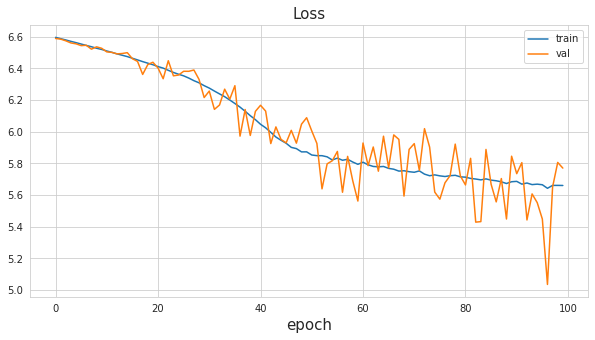

In [63]:
#model with batches old rus emb W2v

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'], embedding_src)
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1, embedding=embedding_trg)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

Results is worser then with out embeddings. Let's change loss function.

train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]

epochs:   1%|          | 1/100 [00:04<06:37,  4.01s/it]

Epoch train loss 6.593905282020569
Epoch val_loss 6.597452640533447



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]

epochs:   2%|▏         | 2/100 [00:07<06:23,  3.91s/it]

Epoch train loss 6.58533251285553
Epoch val_loss 6.580707550048828



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:   3%|▎         | 3/100 [00:11<06:20,  3.92s/it]

Epoch train loss 6.576848554611206
Epoch val_loss 6.572917461395264



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s]

epochs:   4%|▍         | 4/100 [00:15<06:11,  3.87s/it]

Epoch train loss 6.568276286125183
Epoch val_loss 6.5694708824157715



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s]

epochs:   5%|▌         | 5/100 [00:19<06:04,  3.84s/it]

Epoch train loss 6.559802913665772
Epoch val_loss 6.558074474334717



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.90it/s]

epochs:   6%|▌         | 6/100 [00:23<05:59,  3.83s/it]

Epoch train loss 6.551078343391419
Epoch val_loss 6.557637691497803



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  6.08it/s]

epochs:   7%|▋         | 7/100 [00:26<05:52,  3.79s/it]

Epoch train loss 6.541966342926026
Epoch val_loss 6.54252290725708



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s]

epochs:   8%|▊         | 8/100 [00:30<05:47,  3.77s/it]

Epoch train loss 6.532674527168274
Epoch val_loss 6.525240898132324



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s]

epochs:   9%|▉         | 9/100 [00:34<05:43,  3.77s/it]

Epoch train loss 6.524253487586975
Epoch val_loss 6.538339614868164



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  6.01it/s]

epochs:  10%|█         | 10/100 [00:38<05:38,  3.77s/it]

Epoch train loss 6.515061664581299
Epoch val_loss 6.512387752532959



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.97it/s]

epochs:  11%|█         | 11/100 [00:41<05:34,  3.76s/it]

Epoch train loss 6.505660653114319
Epoch val_loss 6.525813579559326



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]

epochs:  12%|█▏        | 12/100 [00:45<05:31,  3.76s/it]

Epoch train loss 6.496791481971741
Epoch val_loss 6.517226219177246



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  6.02it/s]

epochs:  13%|█▎        | 13/100 [00:49<05:27,  3.76s/it]

Epoch train loss 6.486281943321228
Epoch val_loss 6.496882438659668



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s]

epochs:  14%|█▍        | 14/100 [00:53<05:24,  3.77s/it]

Epoch train loss 6.4745248556137085
Epoch val_loss 6.4474992752075195



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]

epochs:  15%|█▌        | 15/100 [00:57<05:24,  3.81s/it]

Epoch train loss 6.465234160423279
Epoch val_loss 6.436210632324219



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]

epochs:  16%|█▌        | 16/100 [01:01<05:31,  3.95s/it]

Epoch train loss 6.453828501701355
Epoch val_loss 6.423469543457031



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]

epochs:  17%|█▋        | 17/100 [01:05<05:25,  3.92s/it]

Epoch train loss 6.445692610740662
Epoch val_loss 6.417137622833252



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s]

epochs:  18%|█▊        | 18/100 [01:09<05:18,  3.88s/it]

Epoch train loss 6.434229803085327
Epoch val_loss 6.425109386444092



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]

epochs:  19%|█▉        | 19/100 [01:12<05:13,  3.87s/it]

Epoch train loss 6.4232711553573605
Epoch val_loss 6.356411457061768



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.85it/s]

epochs:  20%|██        | 20/100 [01:16<05:09,  3.86s/it]

Epoch train loss 6.411082077026367
Epoch val_loss 6.419991970062256



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]

epochs:  21%|██        | 21/100 [01:20<05:05,  3.87s/it]

Epoch train loss 6.399220967292786
Epoch val_loss 6.369911193847656



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s]

epochs:  22%|██▏       | 22/100 [01:24<05:00,  3.85s/it]

Epoch train loss 6.3833229541778564
Epoch val_loss 6.396045207977295



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]

epochs:  23%|██▎       | 23/100 [01:28<04:55,  3.84s/it]

Epoch train loss 6.370718145370484
Epoch val_loss 6.294754505157471



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s]

epochs:  24%|██▍       | 24/100 [01:32<04:51,  3.83s/it]

Epoch train loss 6.361238980293274
Epoch val_loss 6.344488620758057



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]

epochs:  25%|██▌       | 25/100 [01:35<04:47,  3.84s/it]

Epoch train loss 6.3469667673110965
Epoch val_loss 6.400169372558594



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s]

epochs:  26%|██▌       | 26/100 [01:39<04:42,  3.82s/it]

Epoch train loss 6.3326867580413815
Epoch val_loss 6.353646278381348



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]

epochs:  27%|██▋       | 27/100 [01:43<04:39,  3.83s/it]

Epoch train loss 6.315640950202942
Epoch val_loss 6.357471942901611



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.85it/s]

epochs:  28%|██▊       | 28/100 [01:47<04:36,  3.84s/it]

Epoch train loss 6.298843836784362
Epoch val_loss 6.283315181732178



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs:  29%|██▉       | 29/100 [01:51<04:35,  3.88s/it]

Epoch train loss 6.282875657081604
Epoch val_loss 6.238336563110352



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]

epochs:  30%|███       | 30/100 [01:55<04:30,  3.86s/it]

Epoch train loss 6.2610135793685915
Epoch val_loss 6.29311990737915



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:  31%|███       | 31/100 [01:59<04:29,  3.90s/it]

Epoch train loss 6.24618890285492
Epoch val_loss 6.226187229156494



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]

epochs:  32%|███▏      | 32/100 [02:03<04:25,  3.90s/it]

Epoch train loss 6.224495697021484
Epoch val_loss 6.212314128875732



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]

epochs:  33%|███▎      | 33/100 [02:06<04:22,  3.91s/it]

Epoch train loss 6.205337643623352
Epoch val_loss 6.281935214996338



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:  34%|███▍      | 34/100 [02:10<04:19,  3.93s/it]

Epoch train loss 6.179352712631226
Epoch val_loss 6.094990253448486



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.80it/s]

epochs:  35%|███▌      | 35/100 [02:14<04:14,  3.92s/it]

Epoch train loss 6.153856539726258
Epoch val_loss 6.166872501373291



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]

epochs:  36%|███▌      | 36/100 [02:18<04:10,  3.91s/it]

Epoch train loss 6.127672815322876
Epoch val_loss 6.189648151397705



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]

epochs:  37%|███▋      | 37/100 [02:22<04:04,  3.88s/it]

Epoch train loss 6.101508331298828
Epoch val_loss 6.156989097595215



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]

epochs:  38%|███▊      | 38/100 [02:26<04:00,  3.88s/it]

Epoch train loss 6.073233032226563
Epoch val_loss 6.121788501739502



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]

epochs:  39%|███▉      | 39/100 [02:30<03:57,  3.90s/it]

Epoch train loss 6.046724915504456
Epoch val_loss 6.047092437744141



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  40%|████      | 40/100 [02:34<03:54,  3.91s/it]

Epoch train loss 6.008134961128235
Epoch val_loss 6.015194892883301



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  41%|████      | 41/100 [02:38<03:51,  3.92s/it]

Epoch train loss 5.986008548736573
Epoch val_loss 6.0561089515686035



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  42%|████▏     | 42/100 [02:42<03:48,  3.93s/it]

Epoch train loss 5.950287318229675
Epoch val_loss 5.786808490753174



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  43%|████▎     | 43/100 [02:46<03:52,  4.08s/it]

Epoch train loss 5.927699136734009
Epoch val_loss 5.773398399353027



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

epochs:  44%|████▍     | 44/100 [02:50<03:46,  4.04s/it]

Epoch train loss 5.900880312919616
Epoch val_loss 6.035965442657471



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs:  45%|████▌     | 45/100 [02:54<03:40,  4.00s/it]

Epoch train loss 5.884955096244812
Epoch val_loss 6.034914970397949



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  46%|████▌     | 46/100 [02:58<03:35,  4.00s/it]

Epoch train loss 5.877173614501953
Epoch val_loss 5.972377777099609



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s]

epochs:  47%|████▋     | 47/100 [03:02<03:29,  3.96s/it]

Epoch train loss 5.8545042991638185
Epoch val_loss 5.738810062408447



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]

epochs:  48%|████▊     | 48/100 [03:06<03:25,  3.95s/it]

Epoch train loss 5.849062609672546
Epoch val_loss 5.772481441497803



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]

epochs:  49%|████▉     | 49/100 [03:10<03:20,  3.93s/it]

Epoch train loss 5.837025356292725
Epoch val_loss 5.81716775894165



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  50%|█████     | 50/100 [03:14<03:16,  3.93s/it]

Epoch train loss 5.834360647201538
Epoch val_loss 5.742253303527832



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  51%|█████     | 51/100 [03:18<03:12,  3.94s/it]

Epoch train loss 5.830497813224793
Epoch val_loss 5.581243991851807



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  52%|█████▏    | 52/100 [03:22<03:09,  3.94s/it]

Epoch train loss 5.822987651824951
Epoch val_loss 5.911252021789551



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]

epochs:  53%|█████▎    | 53/100 [03:25<03:04,  3.93s/it]

Epoch train loss 5.82042715549469
Epoch val_loss 5.7971272468566895



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]

epochs:  54%|█████▍    | 54/100 [03:29<03:00,  3.92s/it]

Epoch train loss 5.816126275062561
Epoch val_loss 5.646896839141846



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]

epochs:  55%|█████▌    | 55/100 [03:33<02:56,  3.92s/it]

Epoch train loss 5.802119016647339
Epoch val_loss 6.022405624389648



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]

epochs:  56%|█████▌    | 56/100 [03:37<02:51,  3.90s/it]

Epoch train loss 5.786666059494019
Epoch val_loss 5.55620813369751



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]

epochs:  57%|█████▋    | 57/100 [03:41<02:48,  3.92s/it]

Epoch train loss 5.781387901306152
Epoch val_loss 5.806490421295166



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  58%|█████▊    | 58/100 [03:45<02:45,  3.94s/it]

Epoch train loss 5.790277075767517
Epoch val_loss 5.650689125061035



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  59%|█████▉    | 59/100 [03:49<02:42,  3.96s/it]

Epoch train loss 5.764456176757813
Epoch val_loss 5.76535177230835



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  60%|██████    | 60/100 [03:53<02:38,  3.97s/it]

Epoch train loss 5.784911966323852
Epoch val_loss 5.537547588348389



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  61%|██████    | 61/100 [03:57<02:35,  3.98s/it]

Epoch train loss 5.766739773750305
Epoch val_loss 5.9898176193237305



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

epochs:  62%|██████▏   | 62/100 [04:01<02:31,  4.00s/it]

Epoch train loss 5.759789514541626
Epoch val_loss 5.6615681648254395



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  63%|██████▎   | 63/100 [04:05<02:28,  4.00s/it]

Epoch train loss 5.761168432235718
Epoch val_loss 5.650469779968262



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  64%|██████▍   | 64/100 [04:09<02:24,  4.00s/it]

Epoch train loss 5.748468279838562
Epoch val_loss 5.767765522003174



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  65%|██████▌   | 65/100 [04:13<02:19,  4.00s/it]

Epoch train loss 5.7500138759613035
Epoch val_loss 6.015621662139893



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  66%|██████▌   | 66/100 [04:17<02:15,  3.99s/it]

Epoch train loss 5.750693964958191
Epoch val_loss 5.659114837646484



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  67%|██████▋   | 67/100 [04:21<02:11,  3.98s/it]

Epoch train loss 5.734401845932007
Epoch val_loss 5.664783477783203



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  68%|██████▊   | 68/100 [04:25<02:08,  4.00s/it]

Epoch train loss 5.740200710296631
Epoch val_loss 5.778386116027832



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]

epochs:  69%|██████▉   | 69/100 [04:29<02:04,  4.02s/it]

Epoch train loss 5.72969696521759
Epoch val_loss 5.720313549041748



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  70%|███████   | 70/100 [04:33<02:00,  4.03s/it]

Epoch train loss 5.729259896278381
Epoch val_loss 5.853240489959717



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.60it/s]

epochs:  71%|███████   | 71/100 [04:37<01:56,  4.03s/it]

Epoch train loss 5.71732087135315
Epoch val_loss 5.543896675109863



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]

epochs:  72%|███████▏  | 72/100 [04:41<01:52,  4.02s/it]

Epoch train loss 5.713804817199707
Epoch val_loss 5.559106826782227



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]

epochs:  73%|███████▎  | 73/100 [04:45<01:48,  4.02s/it]

Epoch train loss 5.723319339752197
Epoch val_loss 5.925783634185791



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s]

epochs:  74%|███████▍  | 74/100 [04:49<01:44,  4.03s/it]

Epoch train loss 5.7143900156021115
Epoch val_loss 5.679268836975098



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]

epochs:  75%|███████▌  | 75/100 [04:53<01:40,  4.03s/it]

Epoch train loss 5.725974678993225
Epoch val_loss 5.8612260818481445



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  76%|███████▌  | 76/100 [04:57<01:36,  4.01s/it]

Epoch train loss 5.7068719387054445
Epoch val_loss 5.863227367401123



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  77%|███████▋  | 77/100 [05:01<01:31,  3.99s/it]

Epoch train loss 5.703245973587036
Epoch val_loss 5.576037883758545



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  78%|███████▊  | 78/100 [05:05<01:27,  3.98s/it]

Epoch train loss 5.707396841049194
Epoch val_loss 5.492386817932129



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  79%|███████▉  | 79/100 [05:09<01:23,  3.97s/it]

Epoch train loss 5.692239212989807
Epoch val_loss 5.953464031219482



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

epochs:  80%|████████  | 80/100 [05:13<01:19,  3.97s/it]

Epoch train loss 5.69732882976532
Epoch val_loss 5.709885597229004



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

epochs:  81%|████████  | 81/100 [05:17<01:15,  3.98s/it]

Epoch train loss 5.702298712730408
Epoch val_loss 5.8917460441589355



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  82%|████████▏ | 82/100 [05:21<01:11,  3.99s/it]

Epoch train loss 5.691272854804993
Epoch val_loss 5.682361602783203



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]

epochs:  83%|████████▎ | 83/100 [05:25<01:08,  4.01s/it]

Epoch train loss 5.693688488006591
Epoch val_loss 5.778195858001709



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  84%|████████▍ | 84/100 [05:29<01:03,  4.00s/it]

Epoch train loss 5.690413188934326
Epoch val_loss 5.846102714538574



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  85%|████████▌ | 85/100 [05:33<00:59,  4.00s/it]

Epoch train loss 5.680399322509766
Epoch val_loss 5.364902496337891



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  86%|████████▌ | 86/100 [05:37<00:55,  3.99s/it]

Epoch train loss 5.691502547264099
Epoch val_loss 5.573078155517578



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  87%|████████▋ | 87/100 [05:41<00:51,  3.99s/it]

Epoch train loss 5.686552739143371
Epoch val_loss 5.8554229736328125



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

epochs:  88%|████████▊ | 88/100 [05:45<00:47,  3.99s/it]

Epoch train loss 5.678255581855774
Epoch val_loss 5.508174896240234



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  89%|████████▉ | 89/100 [05:49<00:43,  3.99s/it]

Epoch train loss 5.66730306148529
Epoch val_loss 5.595123291015625



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  90%|█████████ | 90/100 [05:53<00:39,  3.99s/it]

Epoch train loss 5.671780133247376
Epoch val_loss 5.489384174346924



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  91%|█████████ | 91/100 [05:57<00:35,  3.99s/it]

Epoch train loss 5.659448790550232
Epoch val_loss 5.349695205688477



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  92%|█████████▏| 92/100 [06:01<00:31,  3.99s/it]

Epoch train loss 5.674236845970154
Epoch val_loss 5.798705577850342



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

epochs:  93%|█████████▎| 93/100 [06:05<00:27,  4.00s/it]

Epoch train loss 5.66476674079895
Epoch val_loss 5.797606468200684



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  94%|█████████▍| 94/100 [06:09<00:23,  3.99s/it]

Epoch train loss 5.669491791725159
Epoch val_loss 5.597513675689697



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  95%|█████████▌| 95/100 [06:13<00:19,  3.98s/it]

Epoch train loss 5.6649247169494625
Epoch val_loss 5.77473258972168



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

epochs:  96%|█████████▌| 96/100 [06:17<00:15,  3.98s/it]

Epoch train loss 5.647555494308472
Epoch val_loss 5.793699741363525



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  97%|█████████▋| 97/100 [06:21<00:12,  4.00s/it]

Epoch train loss 5.654625391960144
Epoch val_loss 5.6173481941223145



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  98%|█████████▊| 98/100 [06:25<00:07,  3.99s/it]

Epoch train loss 5.650204610824585
Epoch val_loss 6.133842468261719



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  99%|█████████▉| 99/100 [06:29<00:04,  4.01s/it]

Epoch train loss 5.637655329704285
Epoch val_loss 5.606107711791992



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs: 100%|██████████| 100/100 [06:33<00:00,  3.93s/it]


Epoch train loss 5.648701119422912
Epoch val_loss 5.608158111572266


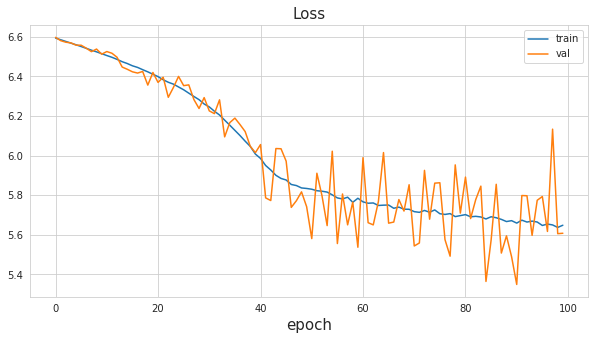

In [62]:
#model with batches old rus emb W2v

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'], embedding_src)
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1, embedding=embedding_trg)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'])
criterion = nn.CrossEntropyLoss(ignore_index = 0)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

Results is as worse as with NLLLos. Let's try to change optimizer to Adam and learning rate.

train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:   1%|          | 1/100 [00:03<06:31,  3.96s/it]

Epoch train loss 6.2640022993087765
Epoch val_loss 5.846193790435791



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.83it/s]

epochs:   2%|▏         | 2/100 [00:07<06:21,  3.90s/it]

Epoch train loss 5.713245129585266
Epoch val_loss 5.668156623840332



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s]

epochs:   3%|▎         | 3/100 [00:11<06:14,  3.86s/it]

Epoch train loss 5.591576099395752
Epoch val_loss 5.782415390014648



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s]

epochs:   4%|▍         | 4/100 [00:15<06:08,  3.84s/it]

Epoch train loss 5.4899855852127075
Epoch val_loss 5.75734806060791



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s]

epochs:   5%|▌         | 5/100 [00:19<06:05,  3.84s/it]

Epoch train loss 5.4478730201721195
Epoch val_loss 5.438293933868408



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s]

epochs:   6%|▌         | 6/100 [00:23<06:01,  3.85s/it]

Epoch train loss 5.387237930297852
Epoch val_loss 5.272310256958008



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]

epochs:   7%|▋         | 7/100 [00:27<05:58,  3.85s/it]

Epoch train loss 5.3111391305923465
Epoch val_loss 5.647964000701904



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s]

epochs:   8%|▊         | 8/100 [00:30<05:55,  3.87s/it]

Epoch train loss 5.242951488494873
Epoch val_loss 5.339038372039795



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:   9%|▉         | 9/100 [00:34<05:53,  3.88s/it]

Epoch train loss 5.169257712364197
Epoch val_loss 5.141279220581055



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.85it/s]

epochs:  10%|█         | 10/100 [00:38<05:48,  3.87s/it]

Epoch train loss 5.070512318611145
Epoch val_loss 4.724236965179443



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  11%|█         | 11/100 [00:42<05:49,  3.92s/it]

Epoch train loss 4.901652145385742
Epoch val_loss 5.096464157104492



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

epochs:  12%|█▏        | 12/100 [00:46<05:46,  3.94s/it]

Epoch train loss 4.750332856178284
Epoch val_loss 5.2501091957092285



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  13%|█▎        | 13/100 [00:50<05:44,  3.96s/it]

Epoch train loss 4.617410898208618
Epoch val_loss 4.664281845092773



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.79it/s]

epochs:  14%|█▍        | 14/100 [00:54<05:38,  3.94s/it]

Epoch train loss 4.457373189926147
Epoch val_loss 4.342886447906494



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]

epochs:  15%|█▌        | 15/100 [00:58<05:33,  3.93s/it]

Epoch train loss 4.279138934612274
Epoch val_loss 4.49826192855835



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.75it/s]

epochs:  16%|█▌        | 16/100 [01:02<05:28,  3.91s/it]

Epoch train loss 4.079500663280487
Epoch val_loss 3.5728018283843994



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

epochs:  17%|█▋        | 17/100 [01:06<05:26,  3.93s/it]

Epoch train loss 3.956409478187561
Epoch val_loss 4.051670074462891



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]

epochs:  18%|█▊        | 18/100 [01:10<05:20,  3.91s/it]

Epoch train loss 3.820358085632324
Epoch val_loss 3.902271270751953



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s]

epochs:  19%|█▉        | 19/100 [01:14<05:15,  3.90s/it]

Epoch train loss 3.6298023104667663
Epoch val_loss 3.5054473876953125



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.81it/s]

epochs:  20%|██        | 20/100 [01:17<05:11,  3.89s/it]

Epoch train loss 3.4201772212982178
Epoch val_loss 3.485813617706299



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]

epochs:  21%|██        | 21/100 [01:21<05:07,  3.89s/it]

Epoch train loss 3.2561954617500306
Epoch val_loss 3.4174933433532715



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s]

epochs:  22%|██▏       | 22/100 [01:25<05:02,  3.88s/it]

Epoch train loss 3.1383493661880495
Epoch val_loss 3.1854195594787598



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.80it/s]

epochs:  23%|██▎       | 23/100 [01:29<04:58,  3.88s/it]

Epoch train loss 3.046004593372345
Epoch val_loss 3.047659158706665



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  24%|██▍       | 24/100 [01:33<04:57,  3.92s/it]

Epoch train loss 2.9386091589927674
Epoch val_loss 3.582350969314575



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

epochs:  25%|██▌       | 25/100 [01:37<04:54,  3.93s/it]

Epoch train loss 2.891484034061432
Epoch val_loss 2.5516486167907715



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

epochs:  26%|██▌       | 26/100 [01:41<04:51,  3.94s/it]

Epoch train loss 2.823275852203369
Epoch val_loss 2.9823639392852783



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

epochs:  27%|██▋       | 27/100 [01:45<04:47,  3.94s/it]

Epoch train loss 2.690042197704315
Epoch val_loss 2.993922710418701



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  28%|██▊       | 28/100 [01:49<04:43,  3.94s/it]

Epoch train loss 2.548836624622345
Epoch val_loss 2.6710901260375977



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  29%|██▉       | 29/100 [01:53<04:39,  3.94s/it]

Epoch train loss 2.4359418511390687
Epoch val_loss 2.694509267807007



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  30%|███       | 30/100 [01:57<04:36,  3.95s/it]

Epoch train loss 2.365323281288147
Epoch val_loss 2.5575857162475586



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  31%|███       | 31/100 [02:01<04:34,  3.97s/it]

Epoch train loss 2.297563499212265
Epoch val_loss 2.678016185760498



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  32%|███▏      | 32/100 [02:05<04:29,  3.96s/it]

Epoch train loss 2.2394703805446623
Epoch val_loss 2.140948534011841



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  33%|███▎      | 33/100 [02:09<04:24,  3.95s/it]

Epoch train loss 2.2011773109436037
Epoch val_loss 2.283557415008545



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]

epochs:  34%|███▍      | 34/100 [02:13<04:20,  3.95s/it]

Epoch train loss 2.1742930710315704
Epoch val_loss 2.2436535358428955



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  35%|███▌      | 35/100 [02:17<04:17,  3.97s/it]

Epoch train loss 2.1123299956321717
Epoch val_loss 1.9603444337844849



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

epochs:  36%|███▌      | 36/100 [02:21<04:13,  3.97s/it]

Epoch train loss 2.057829701900482
Epoch val_loss 2.367568254470825



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.72it/s]

epochs:  37%|███▋      | 37/100 [02:25<04:09,  3.95s/it]

Epoch train loss 2.0451512575149535
Epoch val_loss 1.6467046737670898



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  38%|███▊      | 38/100 [02:28<04:05,  3.95s/it]

Epoch train loss 2.031547212600708
Epoch val_loss 2.035904884338379



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  39%|███▉      | 39/100 [02:32<04:02,  3.97s/it]

Epoch train loss 1.9580005943775176
Epoch val_loss 2.2872278690338135



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]

epochs:  40%|████      | 40/100 [02:36<03:57,  3.96s/it]

Epoch train loss 1.9305383026599885
Epoch val_loss 2.3172190189361572



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  41%|████      | 41/100 [02:40<03:52,  3.95s/it]

Epoch train loss 1.9209735631942748
Epoch val_loss 2.313868999481201



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs:  42%|████▏     | 42/100 [02:44<03:48,  3.94s/it]

Epoch train loss 1.862640482187271
Epoch val_loss 2.0405006408691406



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  43%|████▎     | 43/100 [02:48<03:45,  3.96s/it]

Epoch train loss 1.8171865046024323
Epoch val_loss 2.0169880390167236



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]

epochs:  44%|████▍     | 44/100 [02:52<03:42,  3.97s/it]

Epoch train loss 1.8344192028045654
Epoch val_loss 2.0437827110290527



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:  45%|████▌     | 45/100 [02:56<03:37,  3.96s/it]

Epoch train loss 1.7995323300361634
Epoch val_loss 1.9021697044372559



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  46%|████▌     | 46/100 [03:00<03:34,  3.97s/it]

Epoch train loss 1.8227672934532166
Epoch val_loss 1.8352346420288086



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]

epochs:  47%|████▋     | 47/100 [03:04<03:32,  4.01s/it]

Epoch train loss 1.8160010993480682
Epoch val_loss 2.1271073818206787



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.60it/s]

epochs:  48%|████▊     | 48/100 [03:08<03:29,  4.02s/it]

Epoch train loss 1.766167366504669
Epoch val_loss 2.126375198364258



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  49%|████▉     | 49/100 [03:12<03:26,  4.05s/it]

Epoch train loss 1.8065123200416564
Epoch val_loss 1.7300058603286743



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]

epochs:  50%|█████     | 50/100 [03:17<03:23,  4.06s/it]

Epoch train loss 1.781335312128067
Epoch val_loss 2.0057544708251953



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

epochs:  51%|█████     | 51/100 [03:21<03:19,  4.06s/it]

Epoch train loss 1.7522393345832825
Epoch val_loss 1.5633267164230347



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]

epochs:  52%|█████▏    | 52/100 [03:25<03:14,  4.06s/it]

Epoch train loss 1.7046556264162063
Epoch val_loss 2.0771539211273193



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.63it/s]

epochs:  53%|█████▎    | 53/100 [03:29<03:10,  4.04s/it]

Epoch train loss 1.7006054520606995
Epoch val_loss 1.305897831916809



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]

epochs:  54%|█████▍    | 54/100 [03:33<03:06,  4.06s/it]

Epoch train loss 1.6854216516017915
Epoch val_loss 2.0799319744110107



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]

epochs:  55%|█████▌    | 55/100 [03:37<03:02,  4.06s/it]

Epoch train loss 1.7048063278198242
Epoch val_loss 1.5498912334442139



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

epochs:  56%|█████▌    | 56/100 [03:41<02:58,  4.05s/it]

Epoch train loss 1.6778823554515838
Epoch val_loss 1.7695133686065674



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s]

epochs:  57%|█████▋    | 57/100 [03:45<02:53,  4.04s/it]

Epoch train loss 1.615292054414749
Epoch val_loss 1.3817498683929443



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]

epochs:  58%|█████▊    | 58/100 [03:49<02:49,  4.04s/it]

Epoch train loss 1.65936478972435
Epoch val_loss 1.716181993484497



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]

epochs:  59%|█████▉    | 59/100 [03:53<02:44,  4.02s/it]

Epoch train loss 1.6247166484594344
Epoch val_loss 1.557032823562622



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]

epochs:  60%|██████    | 60/100 [03:57<02:40,  4.02s/it]

Epoch train loss 1.6239067375659944
Epoch val_loss 1.6386951208114624



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]

epochs:  61%|██████    | 61/100 [04:01<02:37,  4.04s/it]

Epoch train loss 1.6036276340484619
Epoch val_loss 1.4300771951675415



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  62%|██████▏   | 62/100 [04:05<02:33,  4.04s/it]

Epoch train loss 1.5972126364707946
Epoch val_loss 1.7481164932250977



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

epochs:  63%|██████▎   | 63/100 [04:09<02:30,  4.07s/it]

Epoch train loss 1.614095890522003
Epoch val_loss 1.2532004117965698



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

epochs:  64%|██████▍   | 64/100 [04:13<02:27,  4.09s/it]

Epoch train loss 1.5992984920740128
Epoch val_loss 1.8563661575317383



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]

epochs:  65%|██████▌   | 65/100 [04:17<02:23,  4.09s/it]

Epoch train loss 1.6320675432682037
Epoch val_loss 1.4787397384643555



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]

epochs:  66%|██████▌   | 66/100 [04:22<02:19,  4.11s/it]

Epoch train loss 1.6733892440795899
Epoch val_loss 1.5814107656478882



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]

epochs:  67%|██████▋   | 67/100 [04:26<02:16,  4.12s/it]

Epoch train loss 1.575401809811592
Epoch val_loss 0.878365695476532



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]

epochs:  68%|██████▊   | 68/100 [04:30<02:12,  4.14s/it]

Epoch train loss 1.603053230047226
Epoch val_loss 1.3556095361709595



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]

epochs:  69%|██████▉   | 69/100 [04:34<02:08,  4.14s/it]

Epoch train loss 1.6219012081623077
Epoch val_loss 1.680418848991394



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

epochs:  70%|███████   | 70/100 [04:38<02:04,  4.15s/it]

Epoch train loss 1.5661946177482604
Epoch val_loss 1.6828553676605225



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

epochs:  71%|███████   | 71/100 [04:42<02:00,  4.16s/it]

Epoch train loss 1.5455333650112153
Epoch val_loss 1.1553746461868286



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

epochs:  72%|███████▏  | 72/100 [04:46<01:56,  4.15s/it]

Epoch train loss 1.508527037501335
Epoch val_loss 1.2933242321014404



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]

epochs:  73%|███████▎  | 73/100 [04:51<01:51,  4.14s/it]

Epoch train loss 1.5006782740354538
Epoch val_loss 0.9135866165161133



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  74%|███████▍  | 74/100 [04:55<01:47,  4.13s/it]

Epoch train loss 1.5056730329990387
Epoch val_loss 1.6908501386642456



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

epochs:  75%|███████▌  | 75/100 [04:59<01:43,  4.13s/it]

Epoch train loss 1.4763283103704452
Epoch val_loss 1.8022654056549072



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]

epochs:  76%|███████▌  | 76/100 [05:03<01:39,  4.13s/it]

Epoch train loss 1.4572150349617004
Epoch val_loss 1.5337162017822266



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]

epochs:  77%|███████▋  | 77/100 [05:07<01:34,  4.11s/it]

Epoch train loss 1.4598676681518554
Epoch val_loss 1.4034039974212646



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.61it/s]

epochs:  78%|███████▊  | 78/100 [05:11<01:29,  4.09s/it]

Epoch train loss 1.4386881053447724
Epoch val_loss 1.2794278860092163



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]

epochs:  79%|███████▉  | 79/100 [05:15<01:25,  4.06s/it]

Epoch train loss 1.4887466609477997
Epoch val_loss 1.4103684425354004



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  80%|████████  | 80/100 [05:19<01:21,  4.06s/it]

Epoch train loss 1.4665701180696487
Epoch val_loss 0.8678581118583679



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.46it/s]

epochs:  81%|████████  | 81/100 [05:23<01:17,  4.07s/it]

Epoch train loss 1.459200856089592
Epoch val_loss 0.602263867855072



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  82%|████████▏ | 82/100 [05:27<01:13,  4.08s/it]

Epoch train loss 1.475807774066925
Epoch val_loss 1.7578577995300293



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

epochs:  83%|████████▎ | 83/100 [05:31<01:09,  4.10s/it]

Epoch train loss 1.4520679503679275
Epoch val_loss 0.903844952583313



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]

epochs:  84%|████████▍ | 84/100 [05:36<01:05,  4.10s/it]

Epoch train loss 1.4526297122240066
Epoch val_loss 1.7905385494232178



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

epochs:  85%|████████▌ | 85/100 [05:40<01:01,  4.10s/it]

Epoch train loss 1.4353993713855744
Epoch val_loss 1.5782119035720825



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]

epochs:  86%|████████▌ | 86/100 [05:44<00:57,  4.07s/it]

Epoch train loss 1.3594483390450478
Epoch val_loss 2.1269514560699463



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]

epochs:  87%|████████▋ | 87/100 [05:48<00:52,  4.03s/it]

Epoch train loss 1.3886829972267152
Epoch val_loss 1.5637333393096924



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.69it/s]

epochs:  88%|████████▊ | 88/100 [05:52<00:48,  4.01s/it]

Epoch train loss 1.4065212860703469
Epoch val_loss 1.0086301565170288



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  89%|████████▉ | 89/100 [05:56<00:43,  3.99s/it]

Epoch train loss 1.4100086957216262
Epoch val_loss 1.1360865831375122



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.73it/s]

epochs:  90%|█████████ | 90/100 [05:59<00:39,  3.98s/it]

Epoch train loss 1.389163401722908
Epoch val_loss 1.5067288875579834



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.83it/s]

epochs:  91%|█████████ | 91/100 [06:03<00:35,  3.96s/it]

Epoch train loss 1.3252729296684265
Epoch val_loss 0.7275575399398804



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.70it/s]

epochs:  92%|█████████▏| 92/100 [06:07<00:31,  3.96s/it]

Epoch train loss 1.343454185128212
Epoch val_loss 1.065704345703125



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs:  93%|█████████▎| 93/100 [06:11<00:27,  3.95s/it]

Epoch train loss 1.3622198045253753
Epoch val_loss 1.5865064859390259



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  94%|█████████▍| 94/100 [06:15<00:23,  3.96s/it]

Epoch train loss 1.3521428018808366
Epoch val_loss 1.5807729959487915



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.76it/s]

epochs:  95%|█████████▌| 95/100 [06:19<00:19,  3.95s/it]

Epoch train loss 1.3412298321723939
Epoch val_loss 2.0692718029022217



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs:  96%|█████████▌| 96/100 [06:23<00:15,  3.94s/it]

Epoch train loss 1.3216193437576294
Epoch val_loss 1.1233515739440918



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s]

epochs:  97%|█████████▋| 97/100 [06:27<00:11,  3.96s/it]

Epoch train loss 1.314593431353569
Epoch val_loss 1.389602541923523



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

epochs:  98%|█████████▊| 98/100 [06:31<00:07,  3.96s/it]

Epoch train loss 1.3169105514883994
Epoch val_loss 1.268541693687439



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs:  99%|█████████▉| 99/100 [06:35<00:03,  3.95s/it]

Epoch train loss 1.2654021441936494
Epoch val_loss 1.1169737577438354



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.74it/s]

epochs: 100%|██████████| 100/100 [06:39<00:00,  3.99s/it]


Epoch train loss 1.268102303147316
Epoch val_loss 1.5800596475601196


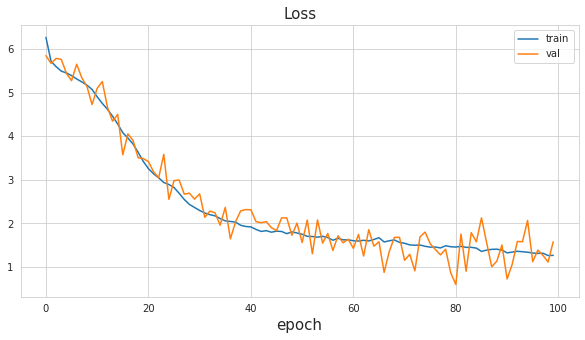

In [64]:
#model with batches old rus emb W2v

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'], embedding_src)
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1, embedding=embedding_trg)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index = 0)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

Result is much better than previous times. Let's check metric. First load best_model.

In [114]:
model_1=torch.load('/content/best_model.pt')

In [117]:
evaluateRandomly(model_1, train_pairs, train_input_lang, train_output_lang, n=10)

> оже придеть кръвавъ мужь на дворъ или синь 
= если придет человек на двор окровавленныи или в синяках 
< если придет человек на двор окровавленныи человек на двор окровавленныи человек на двор окровавленныи человек на двор окровавленныи человек на

Blue score of this sentence  -  0.5623413251903491

> дѣдъ ѥго мартинъ бѧше баскакъ въ градѣ боровьсцѣ 
= его дед мартын был баскаком в городе боровске 
< его дед в боровске в боровске в боровске в боровске в боровске в боровске в боровске в боровске в боровске

Blue score of this sentence  -  0.5773502691896257

> и питьемь 
= и питьем 
< и питьем  

Blue score of this sentence  -  0.7598356856515925

> великy и малy раӡсyдити себѧ и смѣтити по промыслy и по добыткy и по своемy имѣнию 
= большому и малому обсудить свое положение и рассчитать сообразно ремеслу и доходам  а также и по своему имуществу 
< большому и и и и и и и и и и и и и и и и и и и

Blue score of this sentence  -  0.4728708045015879

> състрѣляти самого того диавола 
= по

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


< у князеи умножились сыновья  сыновья  сыновья  сыновья  сыновья  сыновья  сыновья  сыновья  сыновья

Blue score of this sentence  -  0.5475182535069453

> ѿ дѣтьства бо ѥго нѣсть кто имъ оyдарилъ 
= с детства его никто не бросил оземь 
< с детства его никто не бросил оземь  бросил

Blue score of this sentence  -  0.5946035575013605

> и поносъ  и оукоризна сие съ любовию приимати 
= и поношение  и укоризну с любовью принимать 
< и поношение  и поношение  и поношение  и поношение  и поношение  и поношение  и поношение

Blue score of this sentence  -  0.5773502691896257



Not bad for train data. Let's look at test data.

In [119]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang, n=5)

> тако похвалю бога 
= так я хвалю бога и тогда 
< ягненок иосиф иосиф     иосиф

Blue score of this sentence  -  0.7311104457090247

> егда бо болѣзнь напоѥньми и обѧӡаниѥмъ повинyти не въӡмогyть 
= если они болезнь настоями и перевязками победить не могут 
< я          

Blue score of this sentence  -  0

> въ нощи же слышахъ  яко врата домy моего отверзошасѧ 
= ночью же я услышал  как ворота моего дома отворились 
< я   же        

Blue score of this sentence  -  0.5491004867761125

> токмо с пригожествы плавательными подняти морския беды 
= ведь только с принадлежностями для мореходства можно одолеть трудности морские 
< я же                  

Blue score of this sentence  -  0

> иже баскаки нарицаеть тѣхъ языка рѣчь 
= и кто называется на языке тех народов баскаками 
< то же                  

Blue score of this sentence  -  0



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [125]:
evaluateRandomly(model_1, test_pairs, test_input_lang, test_output_lang, n=5)

> егда бо болѣзнь напоѥньми и обѧӡаниѥмъ повинyти не въӡмогyть 
= если они болезнь настоями и перевязками победить не могут 
< я же                  

Blue score of this sentence  -  0

> тако похвалю бога 
= так я хвалю бога и тогда 
< ягненок же                  

Blue score of this sentence  -  0.6147881529512643

> поставленыя по градомъ  аще которыи не креститсѧ 
= поставленных по городам  которые не крестятся 
< останки же когтями растерзающии  сказал: же когтями растерзающии  сказал: же когтями растерзающии  сказал: же когтями растерзающии 

Blue score of this sentence  -  0

> иже баскаки нарицаеть тѣхъ языка рѣчь 
= и кто называется на языке тех народов баскаками 
< то же                  

Blue score of this sentence  -  0

> братъ твоi ярославъ побѣглъ
= твои брат ярослав уже убежал
< а     

Blue score of this sentence  -  0



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


What else can be done?
I try use scheduler for learning rate control.
And BPE tokenizer to apply.

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
                            factor=0.95, threshold=0.1, min_lr=0.005, verbose=True)

In [52]:
def evaluate(model, pairs, input_lang=train_input_lang, output_lang=train_output_lang):
    outputs=[]        
    input_tensor = tensorFromSentence(input_lang, pairs[0], config['MAX_LENGTH'])
    input_len=torch.tensor([len(pairs[0].split(' '))], dtype=torch.int64)
    target_tensor=tensorFromSentence(output_lang, pairs[1], config['MAX_LENGTH'])
                
    output_words, attention = model(input_tensor.reshape(1,20), input_len, target_tensor.reshape(1,20), evalute=True)    
        
    result=output_words.argmax(2).detach()
    result=result.squeeze(0)
        
    for idx in range(result.shape[0]):
        tok=train_output_lang.index2word[result[idx].item()]
        if tok=='EOS':
          break
        outputs.append(tok) 
             
        output_sentence = ' '.join(outputs)
    return    outputs,  attention

In [222]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze().cpu().detach()
    a=torch.zeros(len(attention), len(attention))
    for idx in range(len(attention)):
      a[idx,idx]=attention[idx]
    cax = ax.matshow(a.numpy(), cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
    print(y_ticks) 
    ax.set_xticklabels(x_ticks, rotation=90)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model, input_sentence)
    print('input =', input_sentence[0])
    print('output =', ' '.join(output_words))
    attentions=attentions.detach()
    
    display_attention(input_sentence[0].split(' '), output_words, attentions)



input = останкы же ногътьми растьрӡая
output = останки же когтями растерзающии  растерзающии
['', 'останки', 'же', 'когтями', 'растерзающии', '', 'растерзающии']


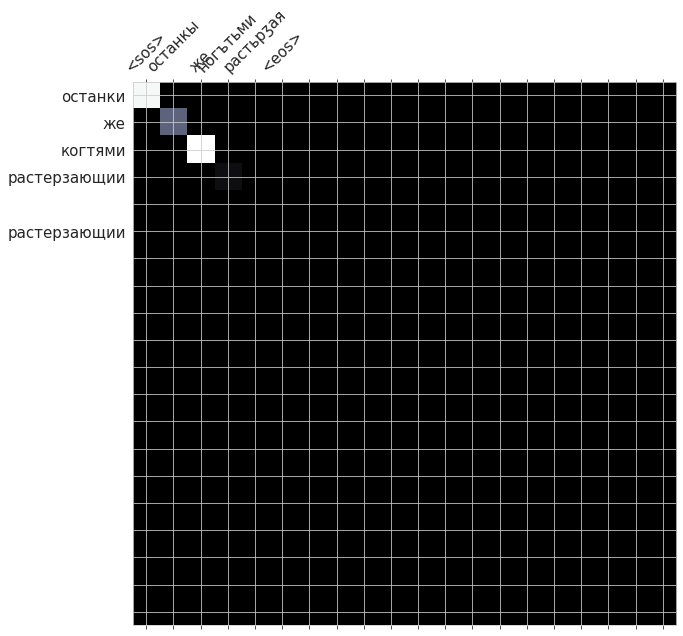

In [ ]:
evaluateAndShowAttention(random.choice(train_pairs))



input = и пріде ѥдинъ старъ мyжь
output = и пришел один старыи человек человек человек человек человек человек человек человек человек человек человек человек человек человек человек человек
['', 'и', 'пришел', 'один', 'старыи', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек', 'человек']


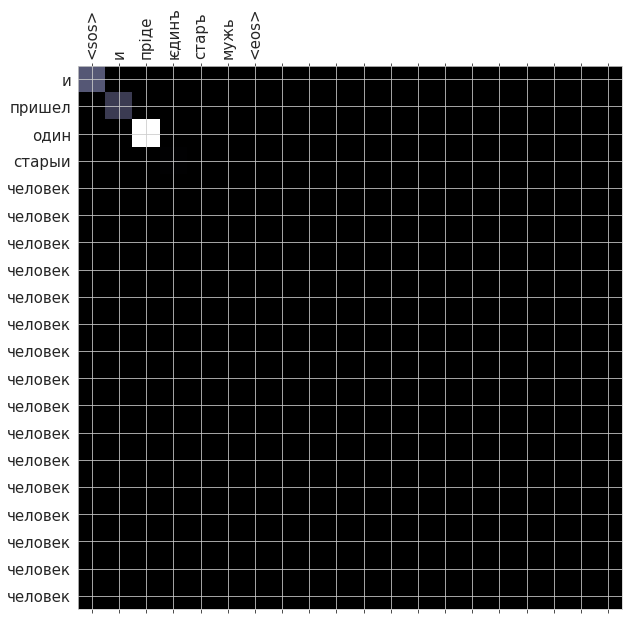

In [221]:
evaluateAndShowAttention(random.choice(train_pairs))


Let's try Adam optimaizer for model without Word2Vec embaddings

In [193]:
def predict(model, input_tensor, input_len, max_len=config['MAX_LENGTH']):
        
        input_length = input_tensor.size(1)        
        target_length=max_len
        batch_size=1

        input_mask=model.create_mask(input_tensor)        
        encoder_hidden= model.encoder.initHidden(batch_size)         
           
        encoder_output, encoder_hidden = model.encoder(input_tensor, input_len, encoder_hidden)
                
        decoder_input=torch.zeros( batch_size, dtype=torch.int32).to(device)                  
        decoder_outputs = torch.zeros((batch_size, target_length, model.decoder.output_size), device=device)
        decoder_attentions = torch.zeros(target_length, target_length)

        for di in range(target_length):
                  
            decoder_output, decoder_hidden, decoder_attention = model.decoder(
                  decoder_input, encoder_hidden, encoder_output, input_mask)                        
            decoder_attentions[di]=decoder_attention
               
            topv, topi = decoder_output.topk(1,1)
            decoder_input = topi.detach() # detach from history as input
            decoder_outputs[:,di]=decoder_output
            if  decoder_input.sum() ==0:
               break
                
        return decoder_outputs, decoder_attentions 

def get_result_attention(model, pair, input_lang=train_input_lang,  max_len=config['MAX_LENGTH']):
        outputs=[]        
        input_tensor = tensorFromSentence(input_lang, pair, config['MAX_LENGTH'])
        input_len=torch.tensor([len(pair.split(' '))], dtype=torch.int64) #length of sentence 
        target_tensor= torch.ones((1,20))
        decoder_outputs, decoder_attentions=predict(model, input_tensor.permute(1, 0), input_len, max_len=config['MAX_LENGTH'])

        result=decoder_outputs.argmax(2).detach() 
        result=result.squeeze(0)
        outputs=[]
        for idx in range(result.shape[0]):
          tok=train_output_lang.index2word[result[idx].item()]
          if tok=='EOS':
            break
          outputs.append(tok)
        return outputs, torch.diagonal(decoder_attentions,0)

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='hsv')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
    print(y_ticks) 
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = get_result_attention(model, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    attentions=attentions.detach()
    print(attentions)
    #showAttention(input_sentence[0], output_words, attentions)
    display_attention(input_sentence.split(' '), output_words, attentions)
        


train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:   1%|          | 1/100 [00:04<08:14,  5.00s/it]

Epoch train loss 6.032247877120971
Epoch val_loss 6.0856733322143555



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]

epochs:   2%|▏         | 2/100 [00:10<08:25,  5.16s/it]

Epoch train loss 5.4438087940216064
Epoch val_loss 5.440493583679199



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

epochs:   3%|▎         | 3/100 [00:14<07:44,  4.79s/it]

Epoch train loss 5.085332155227661
Epoch val_loss 5.396402359008789



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:   4%|▍         | 4/100 [00:18<07:22,  4.61s/it]

Epoch train loss 4.731737041473389
Epoch val_loss 4.7452802658081055



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

epochs:   5%|▌         | 5/100 [00:23<07:09,  4.52s/it]

Epoch train loss 4.299163365364075
Epoch val_loss 3.9794349670410156



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

epochs:   6%|▌         | 6/100 [00:27<07:00,  4.48s/it]

Epoch train loss 3.8398061990737915
Epoch val_loss 3.602318286895752



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:   7%|▋         | 7/100 [00:32<06:52,  4.43s/it]

Epoch train loss 3.362014651298523
Epoch val_loss 3.6685149669647217



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:   8%|▊         | 8/100 [00:36<06:45,  4.41s/it]

Epoch train loss 2.9323233366012573
Epoch val_loss 2.910546064376831



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:   9%|▉         | 9/100 [00:40<06:37,  4.37s/it]

Epoch train loss 2.5647244691848754
Epoch val_loss 2.956761360168457



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  10%|█         | 10/100 [00:45<06:33,  4.37s/it]

Epoch train loss 2.3294318199157713
Epoch val_loss 1.9182236194610596



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  11%|█         | 11/100 [00:49<06:29,  4.38s/it]

Epoch train loss 2.142307472229004
Epoch val_loss 1.9402755498886108



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  12%|█▏        | 12/100 [00:53<06:22,  4.35s/it]

Epoch train loss 2.0256441116333006
Epoch val_loss 2.0906853675842285



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

epochs:  13%|█▎        | 13/100 [00:58<06:18,  4.35s/it]

Epoch train loss 1.9135942697525024
Epoch val_loss 2.1352715492248535



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

epochs:  14%|█▍        | 14/100 [01:02<06:12,  4.33s/it]

Epoch train loss 1.8459121823310851
Epoch val_loss 1.666166067123413



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:  15%|█▌        | 15/100 [01:06<06:09,  4.35s/it]

Epoch train loss 1.768726509809494
Epoch val_loss 1.9573606252670288



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  16%|█▌        | 16/100 [01:11<06:08,  4.39s/it]

Epoch train loss 1.729763001203537
Epoch val_loss 1.5353020429611206



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  17%|█▋        | 17/100 [01:15<06:03,  4.38s/it]

Epoch train loss 1.688917076587677
Epoch val_loss 1.801443099975586



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

epochs:  18%|█▊        | 18/100 [01:20<06:00,  4.40s/it]

Epoch train loss 1.639524018764496
Epoch val_loss 1.5632551908493042



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  19%|█▉        | 19/100 [01:24<05:56,  4.40s/it]

Epoch train loss 1.6080493569374084
Epoch val_loss 1.3026930093765259



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  20%|██        | 20/100 [01:28<05:52,  4.41s/it]

Epoch train loss 1.5945408999919892
Epoch val_loss 1.7519409656524658



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  21%|██        | 21/100 [01:33<05:45,  4.38s/it]

Epoch train loss 1.5608102798461914
Epoch val_loss 1.4300034046173096



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  22%|██▏       | 22/100 [01:37<05:40,  4.37s/it]

Epoch train loss 1.509254914522171
Epoch val_loss 1.6631443500518799



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  23%|██▎       | 23/100 [01:41<05:35,  4.35s/it]

Epoch train loss 1.5047107100486756
Epoch val_loss 1.5189595222473145



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  24%|██▍       | 24/100 [01:46<05:29,  4.34s/it]

Epoch train loss 1.4713528126478195
Epoch val_loss 1.1835869550704956



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

epochs:  25%|██▌       | 25/100 [01:50<05:26,  4.35s/it]

Epoch train loss 1.4254741668701172
Epoch val_loss 1.411563515663147



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  26%|██▌       | 26/100 [01:54<05:21,  4.35s/it]

Epoch train loss 1.4128466606140138
Epoch val_loss 1.6923543214797974



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  27%|██▋       | 27/100 [01:59<05:17,  4.35s/it]

Epoch train loss 1.3648688584566115
Epoch val_loss 1.449210286140442



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  28%|██▊       | 28/100 [02:03<05:13,  4.35s/it]

Epoch train loss 1.3298570066690445
Epoch val_loss 1.6900542974472046



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:  29%|██▉       | 29/100 [02:07<05:09,  4.36s/it]

Epoch train loss 1.2997149258852005
Epoch val_loss 0.5337128639221191



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  30%|███       | 30/100 [02:12<05:04,  4.35s/it]

Epoch train loss 1.3070457518100738
Epoch val_loss 1.1291996240615845



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  31%|███       | 31/100 [02:16<05:01,  4.37s/it]

Epoch train loss 1.262902121245861
Epoch val_loss 1.457312822341919



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  32%|███▏      | 32/100 [02:21<04:58,  4.39s/it]

Epoch train loss 1.2251218393445016
Epoch val_loss 1.20107901096344



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:  33%|███▎      | 33/100 [02:25<04:52,  4.36s/it]

Epoch train loss 1.2117724850773812
Epoch val_loss 1.1565560102462769



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  34%|███▍      | 34/100 [02:29<04:47,  4.36s/it]

Epoch train loss 1.2206261247396468
Epoch val_loss 1.5671662092208862



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:  35%|███▌      | 35/100 [02:34<04:42,  4.34s/it]

Epoch train loss 1.1477470308542252
Epoch val_loss 1.0369590520858765



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  36%|███▌      | 36/100 [02:38<04:37,  4.33s/it]

Epoch train loss 1.103741890192032
Epoch val_loss 0.8192510604858398



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.18it/s]

epochs:  37%|███▋      | 37/100 [02:42<04:32,  4.33s/it]

Epoch train loss 1.0458684861660004
Epoch val_loss 0.4188251495361328



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  38%|███▊      | 38/100 [02:47<04:29,  4.35s/it]

Epoch train loss 1.0825186014175414
Epoch val_loss 1.3176050186157227



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  39%|███▉      | 39/100 [02:51<04:26,  4.36s/it]

Epoch train loss 1.0459001660346985
Epoch val_loss 1.5955764055252075



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  40%|████      | 40/100 [02:55<04:23,  4.39s/it]

Epoch train loss 1.012557190656662
Epoch val_loss 0.8347234725952148



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  41%|████      | 41/100 [03:00<04:19,  4.39s/it]

Epoch train loss 1.0043549351394176
Epoch val_loss 1.4396851062774658



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  42%|████▏     | 42/100 [03:04<04:14,  4.39s/it]

Epoch train loss 0.9640469372272491
Epoch val_loss 0.749449610710144



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

epochs:  43%|████▎     | 43/100 [03:09<04:10,  4.39s/it]

Epoch train loss 0.928245997428894
Epoch val_loss 0.7560725808143616



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

epochs:  44%|████▍     | 44/100 [03:13<04:06,  4.40s/it]

Epoch train loss 0.9752755612134933
Epoch val_loss 0.7575223445892334



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  45%|████▌     | 45/100 [03:17<04:00,  4.38s/it]

Epoch train loss 0.9323348611593246
Epoch val_loss 1.4189518690109253



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

epochs:  46%|████▌     | 46/100 [03:22<03:57,  4.39s/it]

Epoch train loss 0.9033149033784866
Epoch val_loss 1.2529327869415283



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

epochs:  47%|████▋     | 47/100 [03:26<03:52,  4.38s/it]

Epoch train loss 0.8427323367446661
Epoch val_loss 0.5365667343139648



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  48%|████▊     | 48/100 [03:31<03:48,  4.38s/it]

Epoch train loss 0.8317845636978746
Epoch val_loss 1.1153157949447632



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  49%|████▉     | 49/100 [03:35<03:42,  4.36s/it]

Epoch train loss 0.8377049505710602
Epoch val_loss 0.33399784564971924



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  50%|█████     | 50/100 [03:39<03:37,  4.34s/it]

Epoch train loss 0.7869753688573837
Epoch val_loss 0.5965685248374939



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  51%|█████     | 51/100 [03:44<03:33,  4.35s/it]

Epoch train loss 0.8579746566712856
Epoch val_loss 0.533099889755249



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  52%|█████▏    | 52/100 [03:48<03:29,  4.37s/it]

Epoch train loss 0.78709776699543
Epoch val_loss 0.42353713512420654



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

epochs:  53%|█████▎    | 53/100 [03:52<03:24,  4.35s/it]

Epoch train loss 0.7156636707484723
Epoch val_loss 0.720684826374054



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  54%|█████▍    | 54/100 [03:57<03:19,  4.34s/it]

Epoch train loss 0.7694155760109425
Epoch val_loss 0.609412670135498



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  55%|█████▌    | 55/100 [04:01<03:15,  4.35s/it]

Epoch train loss 0.7707192270085216
Epoch val_loss 0.964817464351654



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  56%|█████▌    | 56/100 [04:05<03:11,  4.36s/it]

Epoch train loss 0.7519649669528008
Epoch val_loss 0.9058812856674194



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  57%|█████▋    | 57/100 [04:10<03:08,  4.38s/it]

Epoch train loss 0.733002174180001
Epoch val_loss 0.35241666436195374



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  58%|█████▊    | 58/100 [04:14<03:04,  4.40s/it]

Epoch train loss 0.7382764891721308
Epoch val_loss 0.9102068543434143



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:  59%|█████▉    | 59/100 [04:19<03:00,  4.39s/it]

Epoch train loss 0.7324632231146098
Epoch val_loss 1.1537845134735107



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

epochs:  60%|██████    | 60/100 [04:23<02:56,  4.40s/it]

Epoch train loss 0.7006740361452103
Epoch val_loss 0.20224134624004364



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]

epochs:  61%|██████    | 61/100 [04:28<02:55,  4.49s/it]

Epoch train loss 0.6782481340691447
Epoch val_loss 0.5600955486297607



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  62%|██████▏   | 62/100 [04:32<02:49,  4.47s/it]

Epoch train loss 0.678950251545757
Epoch val_loss 1.0156333446502686



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

epochs:  63%|██████▎   | 63/100 [04:37<02:44,  4.46s/it]

Epoch train loss 0.6637557487934828
Epoch val_loss 0.5801568031311035



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  64%|██████▍   | 64/100 [04:41<02:40,  4.45s/it]

Epoch train loss 0.6679001927375794
Epoch val_loss 0.3367043733596802



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  65%|██████▌   | 65/100 [04:46<02:36,  4.48s/it]

Epoch train loss 0.6564218005165458
Epoch val_loss 1.0481394529342651



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

epochs:  66%|██████▌   | 66/100 [04:50<02:32,  4.50s/it]

Epoch train loss 0.6369777729734778
Epoch val_loss 0.8370004892349243



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  67%|██████▋   | 67/100 [04:54<02:27,  4.48s/it]

Epoch train loss 0.6466258488595485
Epoch val_loss 0.5415194630622864



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  68%|██████▊   | 68/100 [04:59<02:22,  4.45s/it]

Epoch train loss 0.6236596133559942
Epoch val_loss 0.606981635093689



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  69%|██████▉   | 69/100 [05:03<02:17,  4.45s/it]

Epoch train loss 0.5942318209446966
Epoch val_loss 0.2477942407131195



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  70%|███████   | 70/100 [05:08<02:12,  4.43s/it]

Epoch train loss 0.6573226540349424
Epoch val_loss 1.0273798704147339



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]

epochs:  71%|███████   | 71/100 [05:12<02:08,  4.42s/it]

Epoch train loss 0.5686307257972658
Epoch val_loss 0.020828818902373314



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  72%|███████▏  | 72/100 [05:17<02:04,  4.44s/it]

Epoch train loss 0.5933692558668554
Epoch val_loss 0.6651232242584229



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:  73%|███████▎  | 73/100 [05:21<01:59,  4.44s/it]

Epoch train loss 0.5768965995870531
Epoch val_loss 1.5656100511550903



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  74%|███████▍  | 74/100 [05:25<01:55,  4.44s/it]

Epoch train loss 0.6124270314350724
Epoch val_loss 0.37074708938598633



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  75%|███████▌  | 75/100 [05:30<01:51,  4.46s/it]

Epoch train loss 0.5812749835196882
Epoch val_loss 0.7004380226135254



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  76%|███████▌  | 76/100 [05:34<01:46,  4.46s/it]

Epoch train loss 0.592585064470768
Epoch val_loss 0.13250654935836792



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  77%|███████▋  | 77/100 [05:39<01:42,  4.46s/it]

Epoch train loss 0.5999906908720731
Epoch val_loss 0.28004905581474304



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

epochs:  78%|███████▊  | 78/100 [05:43<01:37,  4.45s/it]

Epoch train loss 0.6212914166972041
Epoch val_loss 0.15641385316848755



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s]

epochs:  79%|███████▉  | 79/100 [05:48<01:34,  4.49s/it]

Epoch train loss 0.585962064191699
Epoch val_loss 0.36599990725517273



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

epochs:  80%|████████  | 80/100 [05:52<01:30,  4.51s/it]

Epoch train loss 0.5354200950358063
Epoch val_loss 0.027720972895622253



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  81%|████████  | 81/100 [05:57<01:25,  4.49s/it]

Epoch train loss 0.5796980056911707
Epoch val_loss 1.2673531770706177



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

epochs:  82%|████████▏ | 82/100 [06:01<01:20,  4.49s/it]

Epoch train loss 0.5639813680201768
Epoch val_loss 0.08540809154510498



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  83%|████████▎ | 83/100 [06:06<01:16,  4.52s/it]

Epoch train loss 0.5174425925128162
Epoch val_loss 0.57164466381073



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

epochs:  84%|████████▍ | 84/100 [06:11<01:12,  4.55s/it]

Epoch train loss 0.5732306575402617
Epoch val_loss 0.9678968191146851



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  85%|████████▌ | 85/100 [06:15<01:07,  4.53s/it]

Epoch train loss 0.5644397989846766
Epoch val_loss 0.1255064755678177



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

epochs:  86%|████████▌ | 86/100 [06:20<01:03,  4.57s/it]

Epoch train loss 0.5555728149134666
Epoch val_loss 0.11698233336210251



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  87%|████████▋ | 87/100 [06:24<00:59,  4.57s/it]

Epoch train loss 0.5584689100272954
Epoch val_loss 0.827100932598114



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

epochs:  88%|████████▊ | 88/100 [06:29<00:54,  4.57s/it]

Epoch train loss 0.5364509195555002
Epoch val_loss 0.8850589394569397



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  89%|████████▉ | 89/100 [06:33<00:50,  4.57s/it]

Epoch train loss 0.5381985653191805
Epoch val_loss 0.9732643365859985



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

epochs:  90%|█████████ | 90/100 [06:38<00:45,  4.56s/it]

Epoch train loss 0.5498623168095946
Epoch val_loss 1.0474625825881958



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

epochs:  91%|█████████ | 91/100 [06:43<00:41,  4.56s/it]

Epoch train loss 0.5022545968182385
Epoch val_loss 0.18964767456054688



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  92%|█████████▏| 92/100 [06:47<00:36,  4.56s/it]

Epoch train loss 0.49010572796687485
Epoch val_loss 0.13249769806861877



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  93%|█████████▎| 93/100 [06:52<00:31,  4.54s/it]

Epoch train loss 0.48982374821789565
Epoch val_loss 1.1492342948913574



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  94%|█████████▍| 94/100 [06:56<00:27,  4.52s/it]

Epoch train loss 0.487346599297598
Epoch val_loss 0.3934336006641388



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  95%|█████████▌| 95/100 [07:01<00:22,  4.55s/it]

Epoch train loss 0.5188043820671737
Epoch val_loss 1.2192707061767578



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]

epochs:  96%|█████████▌| 96/100 [07:05<00:18,  4.53s/it]

Epoch train loss 0.5324205855838955
Epoch val_loss 0.6858729124069214



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  97%|█████████▋| 97/100 [07:10<00:13,  4.53s/it]

Epoch train loss 0.5415688612498343
Epoch val_loss 0.3480167090892792



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  98%|█████████▊| 98/100 [07:14<00:09,  4.55s/it]

Epoch train loss 0.5424097416456789
Epoch val_loss 0.7625782489776611



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  99%|█████████▉| 99/100 [07:19<00:04,  4.54s/it]

Epoch train loss 0.5347507131751627
Epoch val_loss 0.23916691541671753



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]

epochs: 100%|██████████| 100/100 [07:23<00:00,  4.44s/it]


Epoch train loss 0.5110451078508049
Epoch val_loss 0.5495069026947021


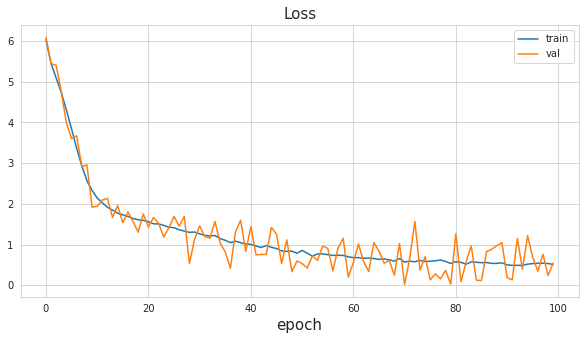

In [ ]:
#model with batches rus-eng

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss(ignore_index=0)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'])

This is the best of all result 

In [ ]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang, n=1)

> да прокъ грѣховъ своихъ покаявъсѧ 
= чтобы впредь  в остальных своих грехах покаявшись 
< чтобы впредь  в остальных своих грехах покаявшись  в

Blue score of this sentence  -  0.5773502691896257



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang, n=10)

> конь на брани разоумѣетъ снѧгоу  дроугоу же въ печали добръ дроугъ пособитъ 
= сила коня познается в сражении  другу же в печали поможет добрыи друг 
< сила коня познается в сражении поможет же в сражении поможет же в сражении поможет же в сражении поможет же в

Blue score of this sentence  -  0.5169731539571706

> сынъ не послyшьливъ отцy или матери  иже прогнѣваеть отца и досажаеть матери 
= сын  непослушныи отцу или матери  которыи гневит отца и досаждает матери 
< сын  матери отцу или матери отцу или матери отцу или матери отцу или матери отцу или матери отцу или

Blue score of this sentence  -  0.5169731539571706

> но платити ему продажю 3 грвн 
= но надлежит заплатить ему 3 гривны продажи 
< но надлежит заплатить ему 3 гривны продажи  3 гривны продажи  3 гривны продажи  3 гривны продажи 

Blue score of this sentence  -  0.5946035575013605

> отъкоудоу соуть и камо идоуть 
= откуда они и куда идут 
< откуда они и куда идут  и куда идут  и куда идут  и куда идут  и куда

Blue sc

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


< а народом проклят  проклят  проклят  проклят  проклят  проклят  проклят  проклят  проклят 

Blue score of this sentence  -  0.7071067811865476

> ино надобѣ всякомy человѣкy тъщеславия бѣгати и похвалы 
= ибо следует каждому человеку избегать тщеславия  и похвал 
< ибо следует каждому человеку избегать тщеславия  и похвал  и

Blue score of this sentence  -  0.5623413251903491

> кто суть и ѿтколе изидоша 
= кто они и откуда вышли 
< кто они и откуда вышли  и откуда вышли  и откуда вышли  и откуда вышли  и откуда

Blue score of this sentence  -  0.6389431042462724

> да егда сѧ приближать к неи  воскочивши и имѣть отъ нихъ ѣсти и тако сѧ кормить
= а когда они приблизятся к неи  вскочив  лиса хватает кого из них себе на прокорм и так себя кормит
< а когда они приблизятся к неи  вскочив  вскочив  вскочив  вскочив  вскочив  вскочив  вскочив

Blue score of this sentence  -  0.6147881529512643

> горлица моужелюбица пътахъ есть 
= горлица – птица  любящая своего супруга 
< горлица – птица 

In [ ]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang, n=10)

> оучнетъ на люди глѧдѧ жити не по силе и ӡаимyя 
= станет  на людеи глядя  жить не по средствам  занимая
< и невидимому  невидимому невидимому змию  змию гораздо змию   отсечь

Blue score of this sentence  -  0

> оже придеть кръвавъ мужь на дворъ или синь 
= если придет человек на двор окровавленныи или в синяках 
< и отсечь главу невидимому змию  невидимому змию  невидимому змию  невидимому змию  невидимому змию  невидимому змию

Blue score of this sentence  -  0.5623413251903491

> глаголю тебѣ да съзижди црьковь братiю събери и монастырь съгради и кѣлiи постави яко благоволю тобою многыѧ дша спсти 
= говорю тебе: построи церковь  собери братию и устрои свои монастырь и поставь кельи  ибо я хочу спасти через тебя многие души 
< и  ни    том  вскоре    вскоре       

Blue score of this sentence  -  0.4518010018049224

> идеже станете 
= там  где вы остановитесь 
< затянулась    невидимому из 

Blue score of this sentence  -  0

> азон радостию возвеселися* многою 
= язон очень обрад

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
